Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [1]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from icecream import ic
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

## 1) Problem instance with:
- UNIVERSE_SIZE = 100
- NUM_SETS = 10
- DENSITY = 0.2
- STEPS = 10000

In [2]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [5]:
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None 

ic| valid(solution): np.True_
    cost(solution): np.float64(331.71525312222707)


In [6]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(177.2007963341056))

## Random Mutation Hill Climbing

In [7]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [8]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))
ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))


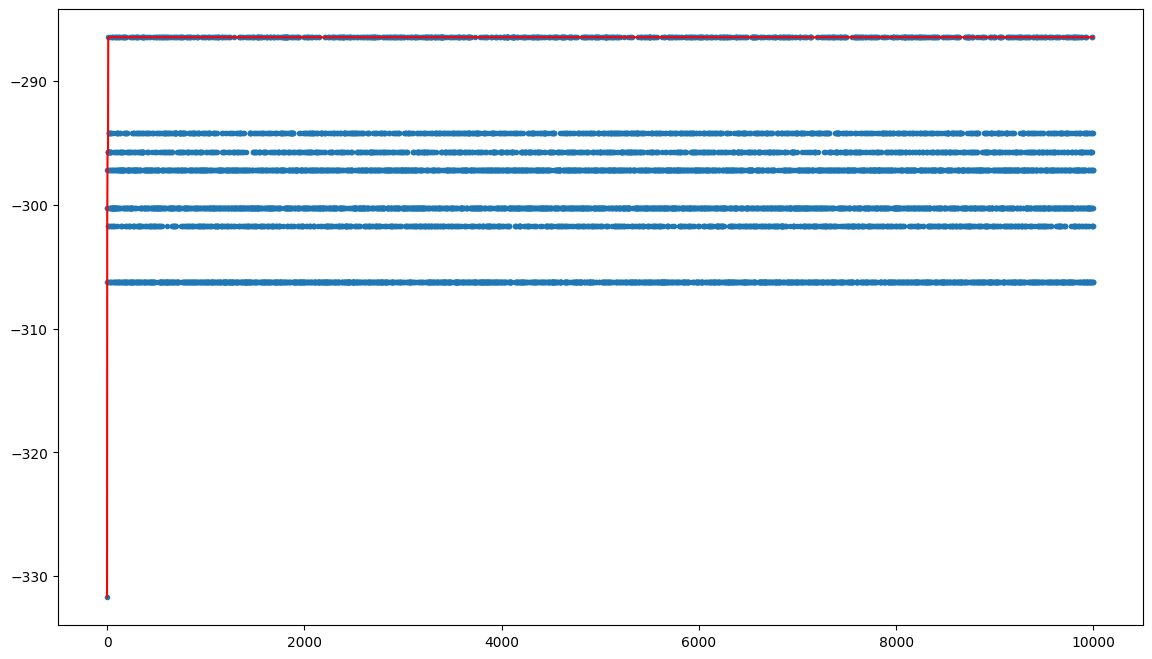

In [9]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [10]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))
ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))


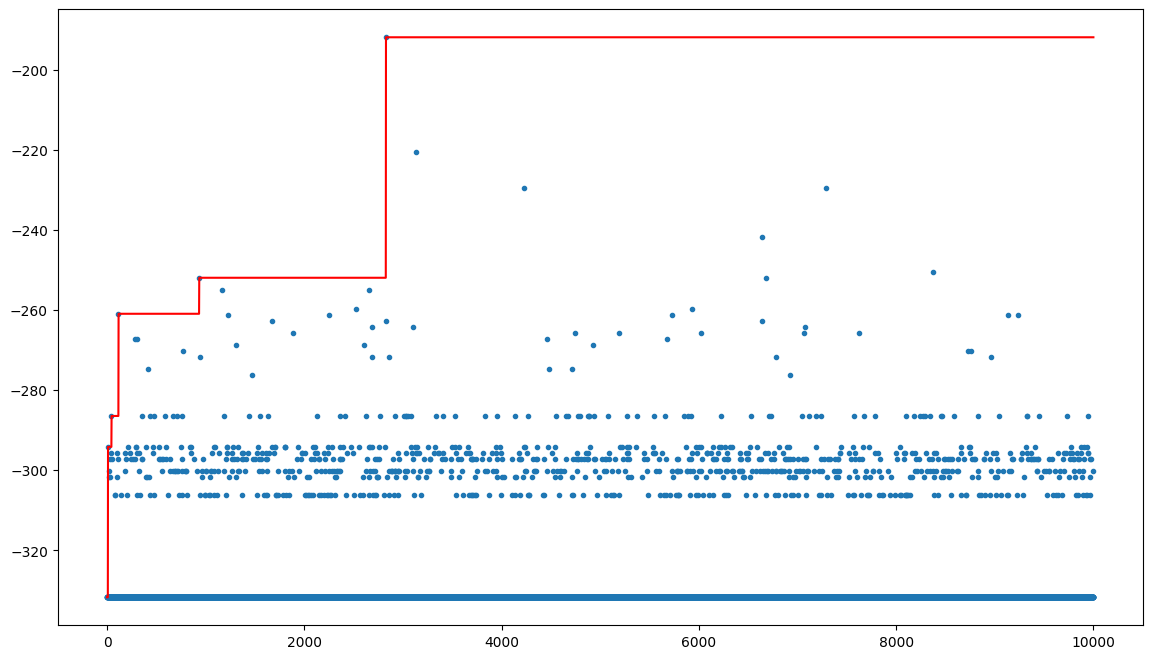

In [11]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [12]:
# strength
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))
ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))


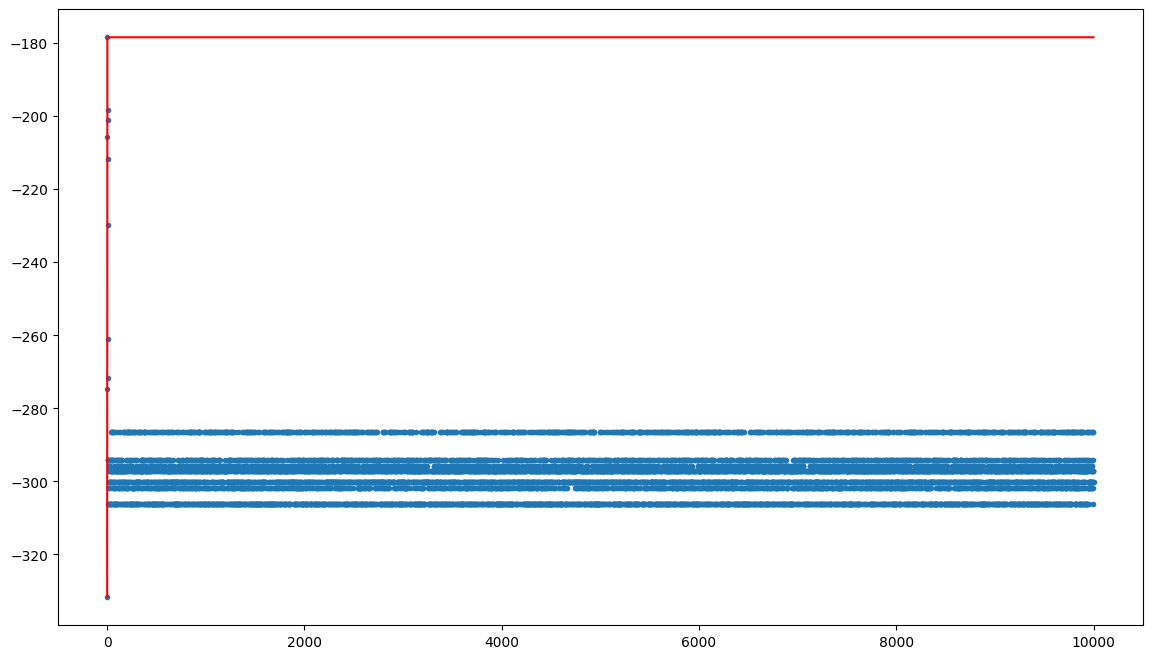

In [13]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(10000):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-331.71525312222707))
ic| fitness(solution): (np.False_, np.float64(-0.0))


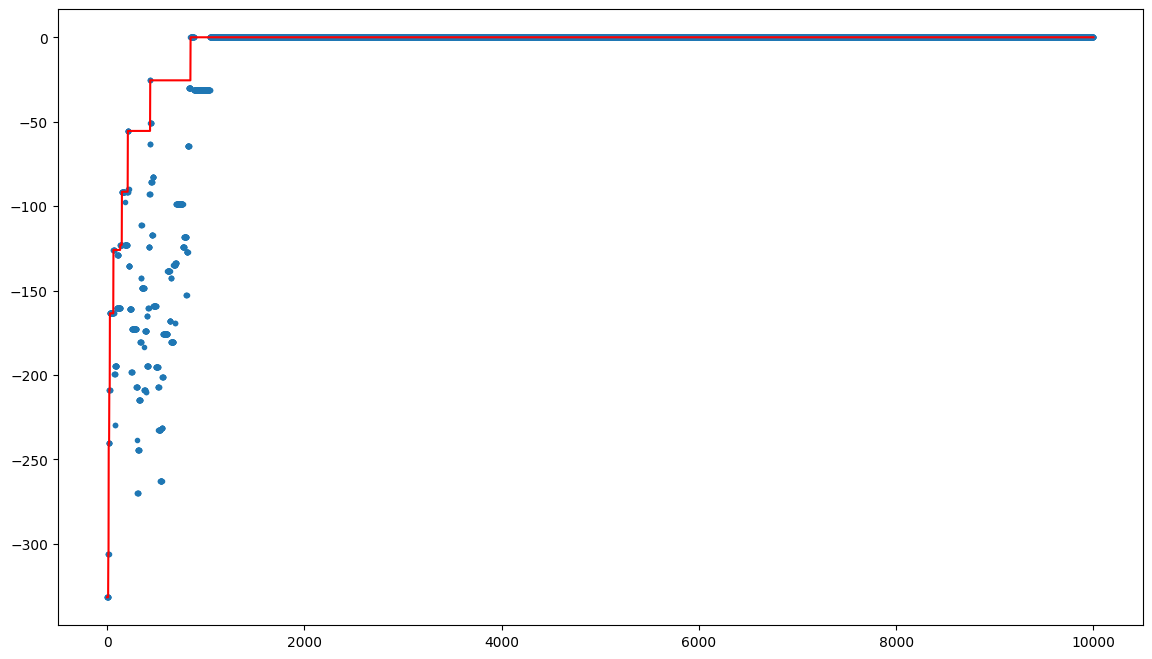

In [14]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995 
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]]  

temperature = INITIAL_TEMPERATURE

for steps in range(10000):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-331.71525312222707))


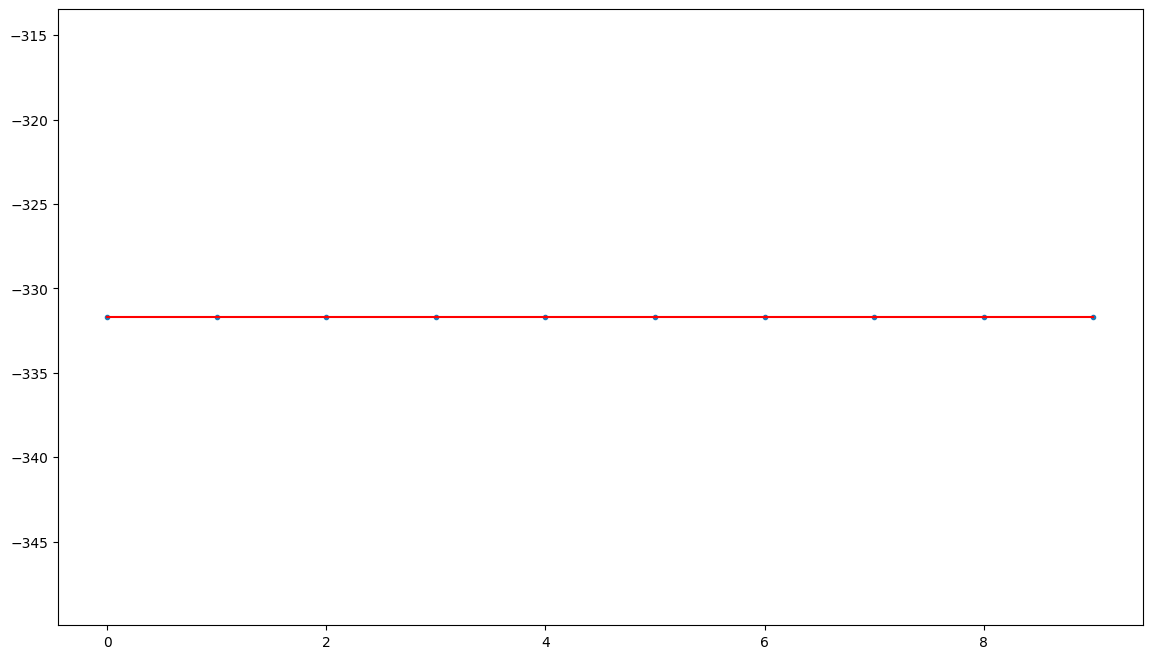

In [16]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def local_search(solution, max_steps=10000):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-331.71525312222707))


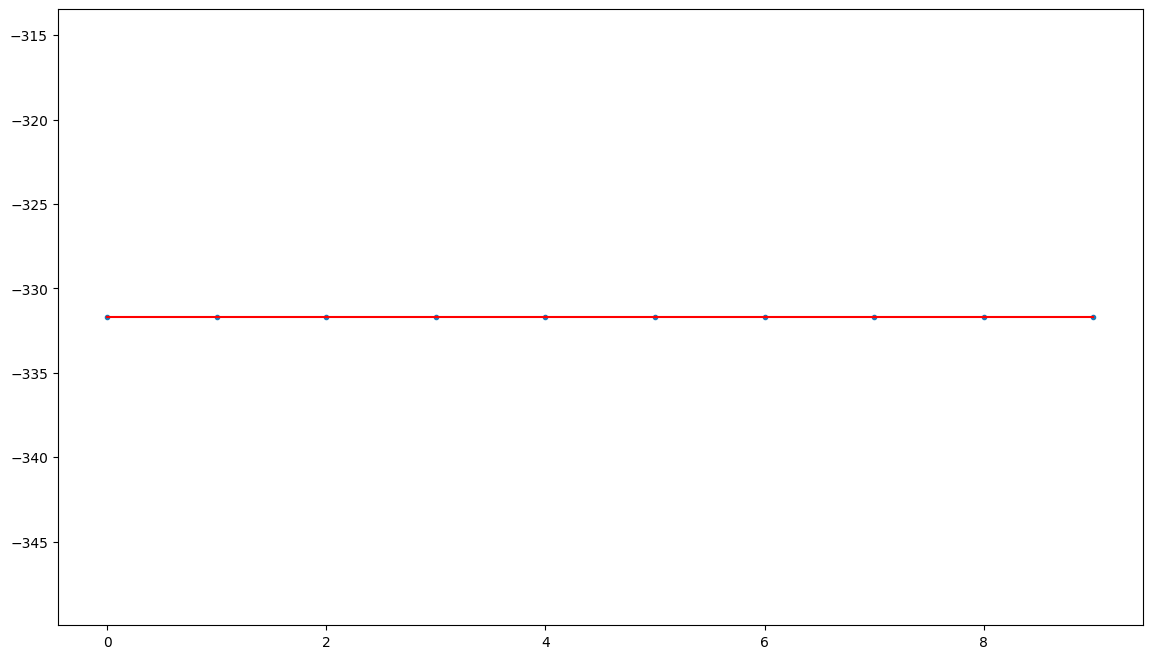

In [17]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=10000):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-331.71525312222707))


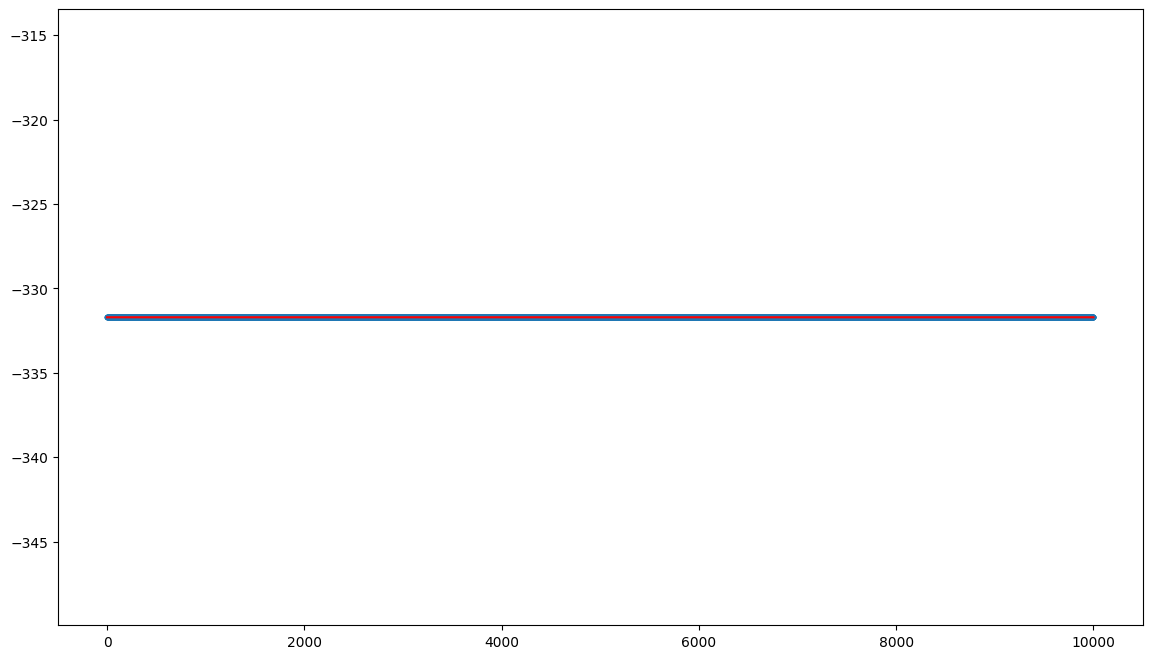

In [18]:
from collections import deque

def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-331.71525312222707))


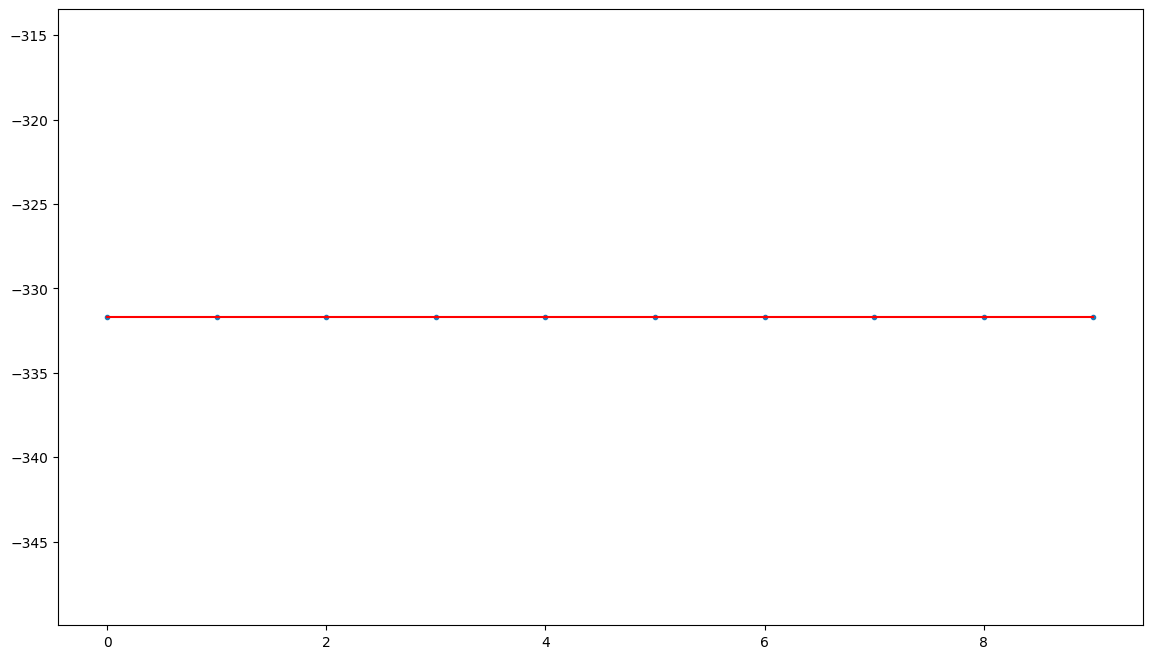

In [19]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-331.71525312222707))


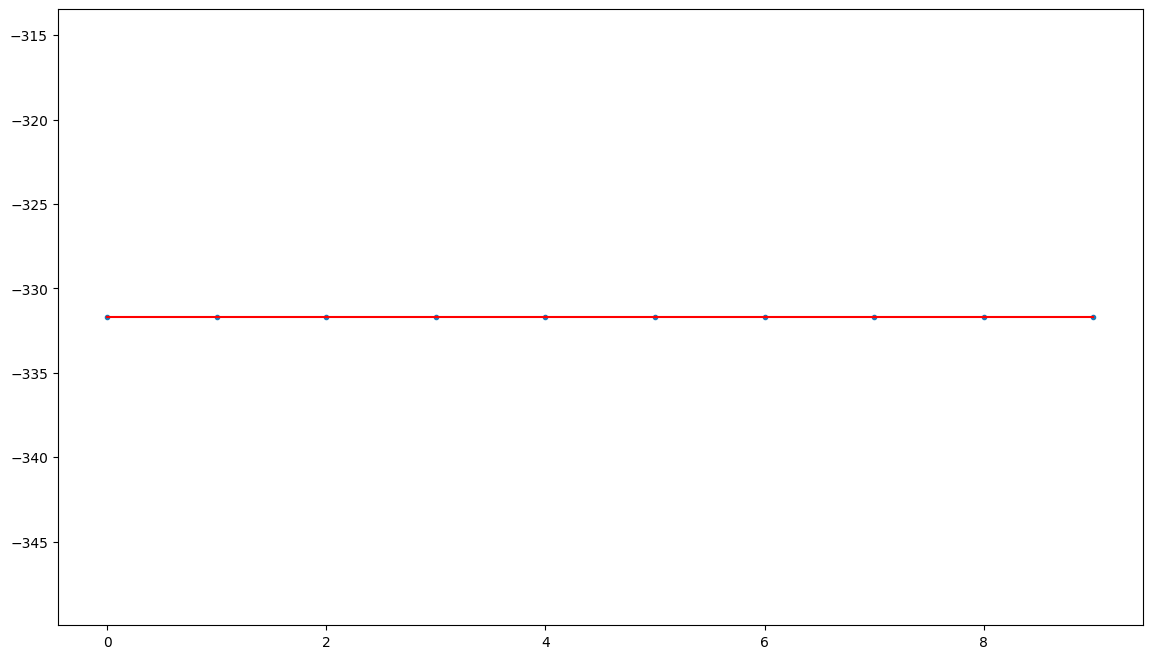

In [20]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=10000):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
    
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## 2) Problem instance with:
- UNIVERSE_SIZE = 1000
- NUM_SETS = 100
- DENSITY = 0.2
- STEPS = 10000

In [21]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [22]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Random Mutation Hill Climbing

In [23]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [24]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-34176.317854846886))
ic| fitness(solution): (np.True_, np.float64(-7308.238696779636))


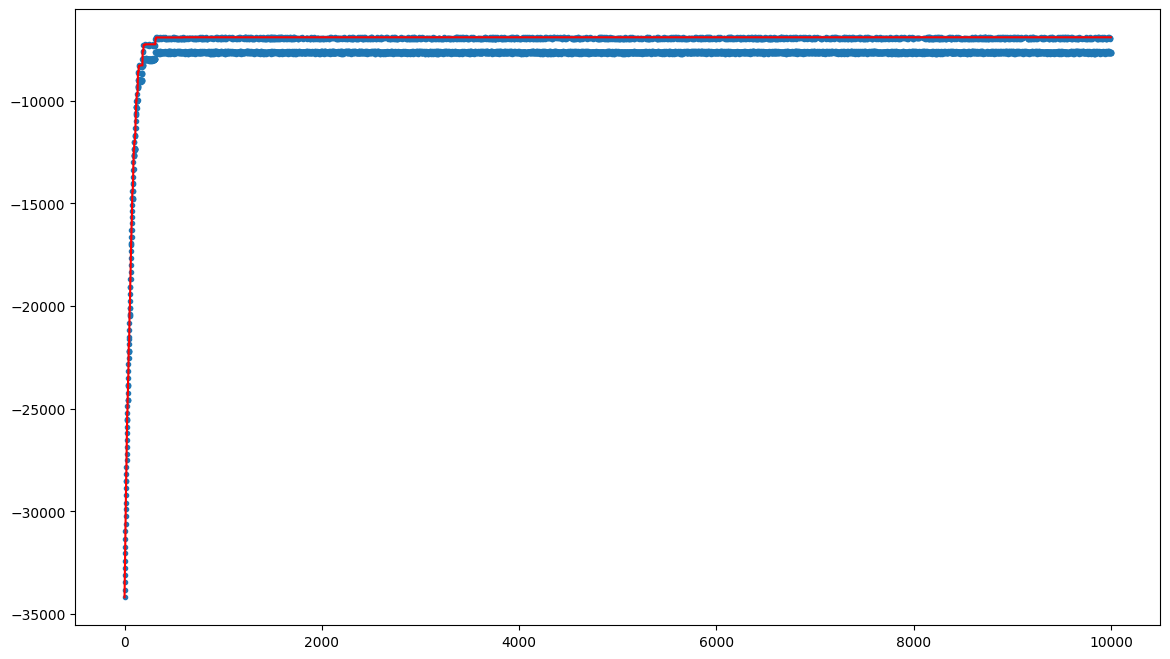

In [25]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [26]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-34176.317854846886))
ic| fitness(solution): (np.True_, np.float64(-6469.3693239528575))


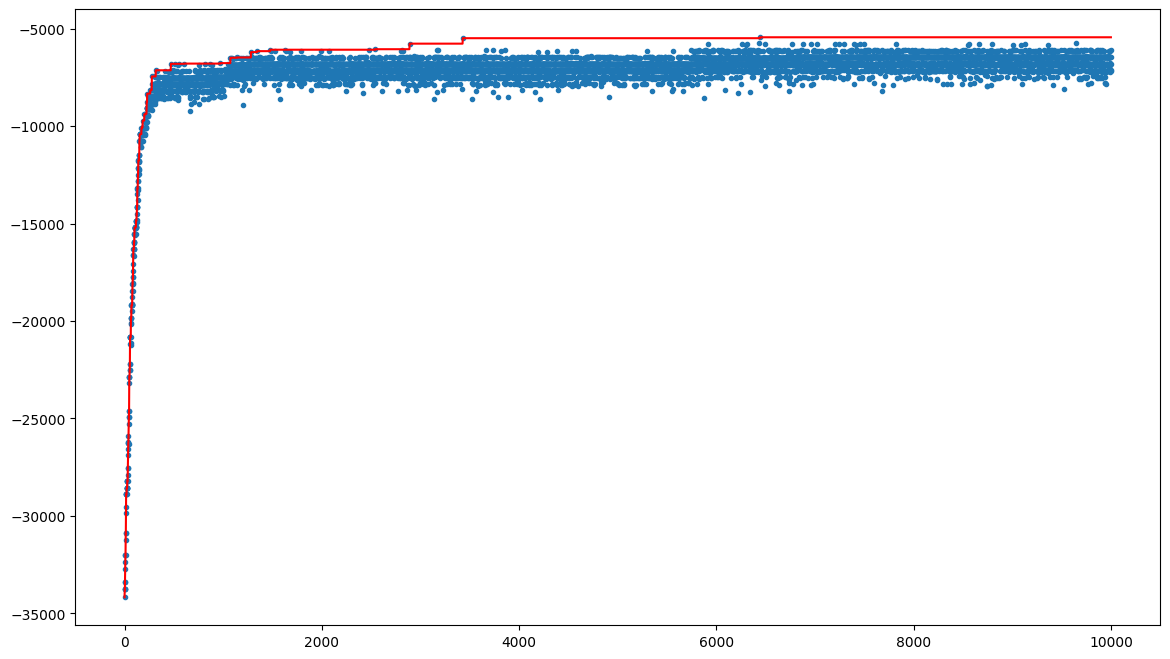

In [27]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [28]:
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-34176.317854846886))
ic| fitness(solution): (np.True_, np.float64(-6990.421611981168))


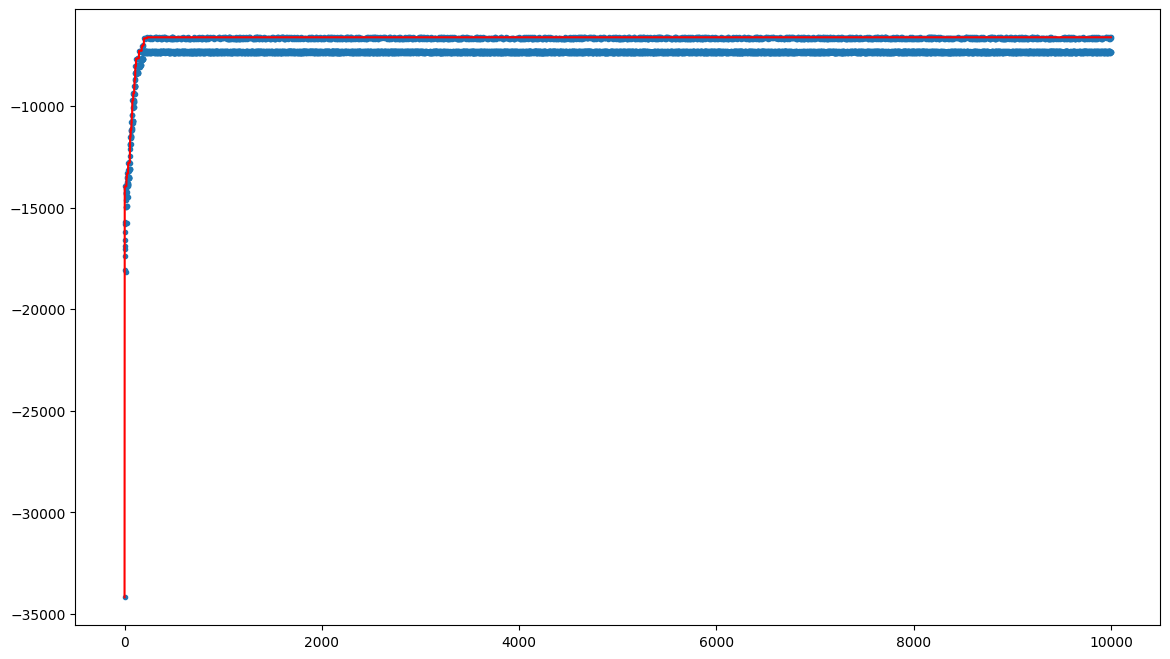

In [29]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(10000):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-34176.317854846886))
ic| fitness(solution): (np.False_, np.float64(-0.0))


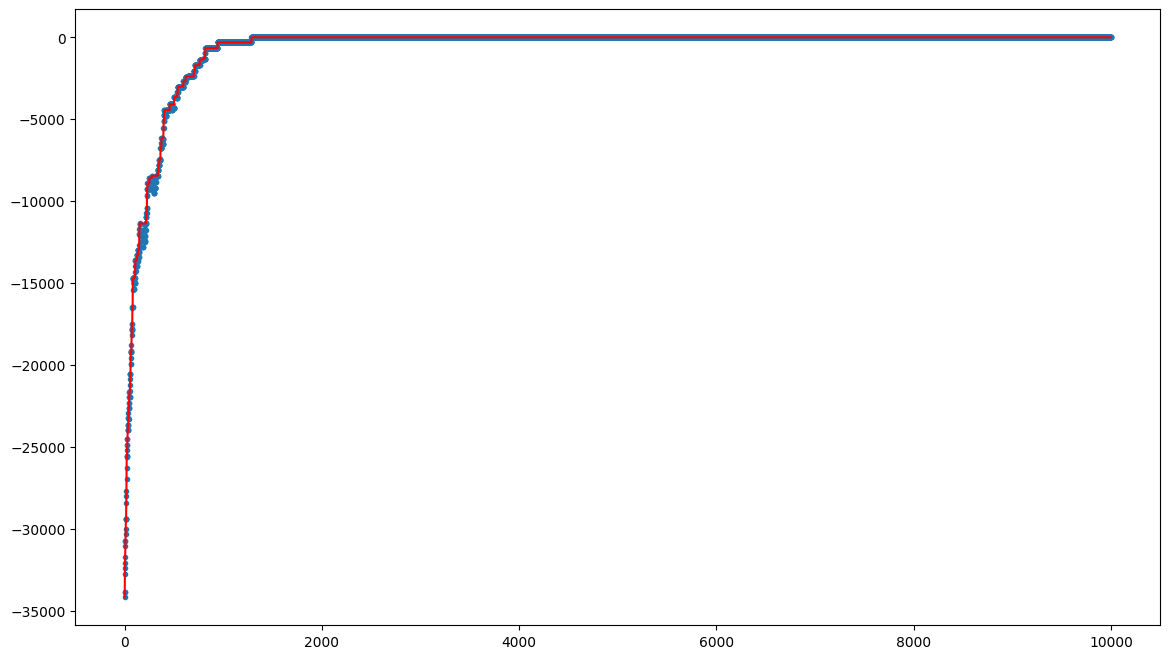

In [30]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995  
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]] 

temperature = INITIAL_TEMPERATURE

for steps in range(10000):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-6047.67583799824))


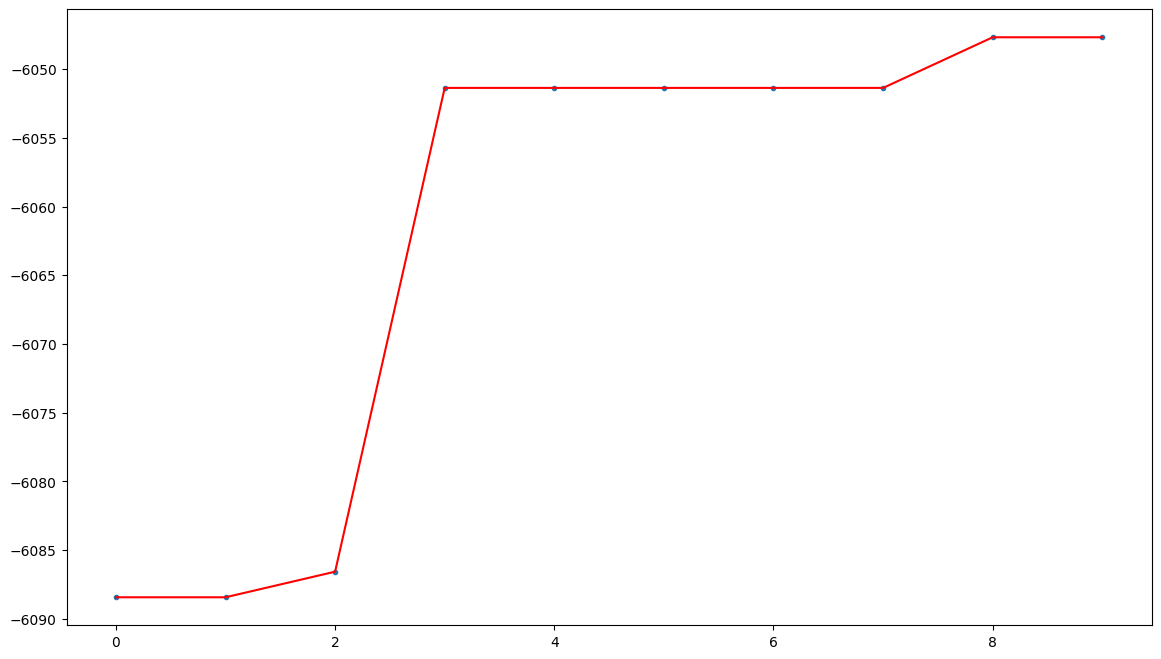

In [31]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=10000):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness


num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []


for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-5985.908556565317))


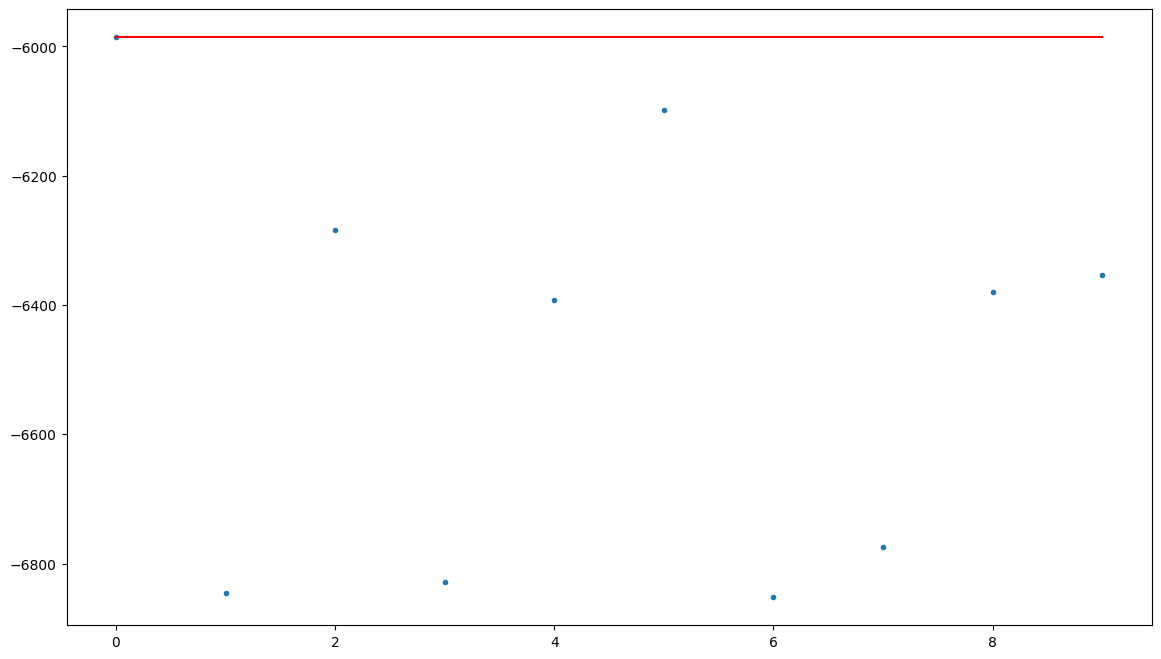

In [32]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=10000):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-6624.71797738842))


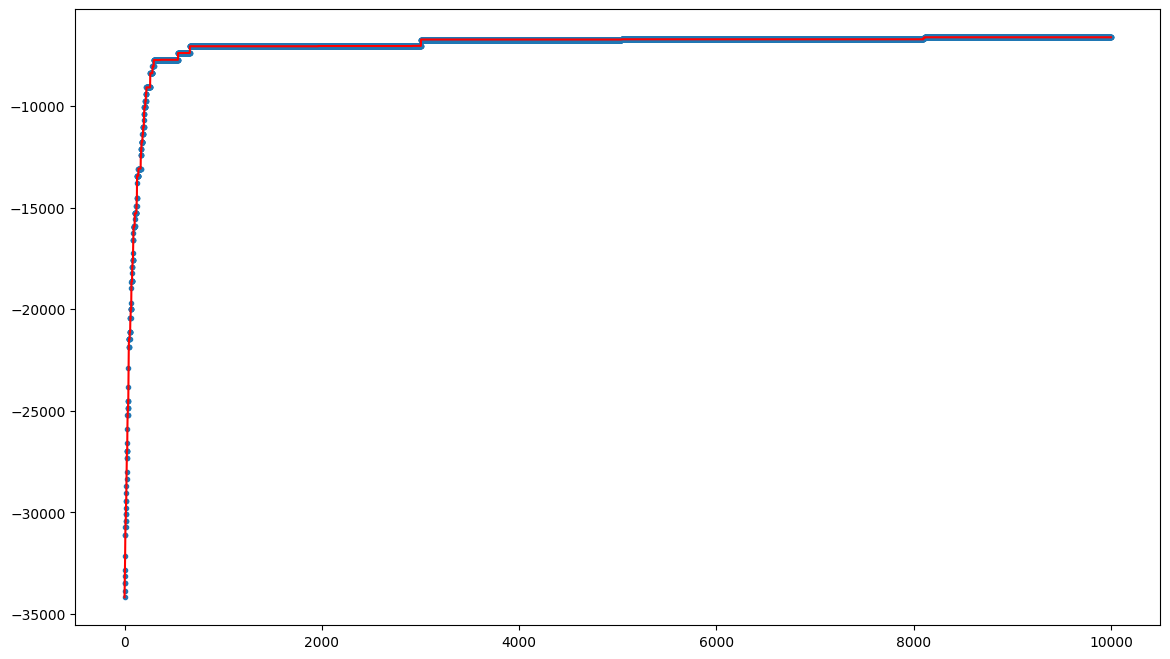

In [33]:

from collections import deque


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-6344.2873136766475))


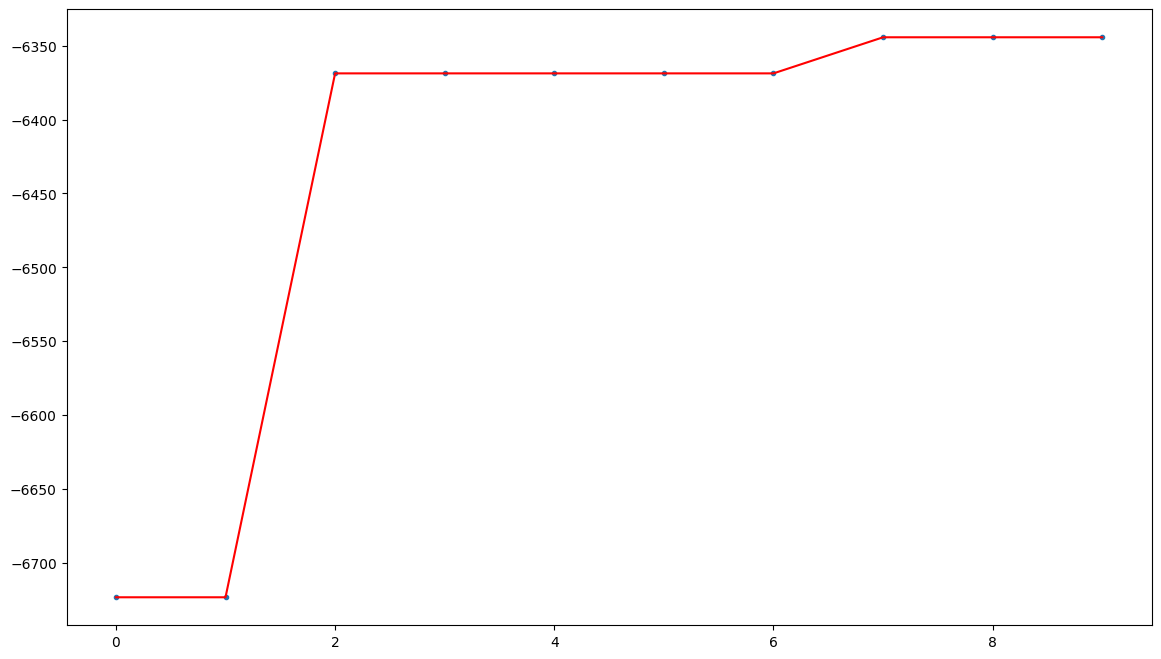

In [34]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-6756.871198068768))


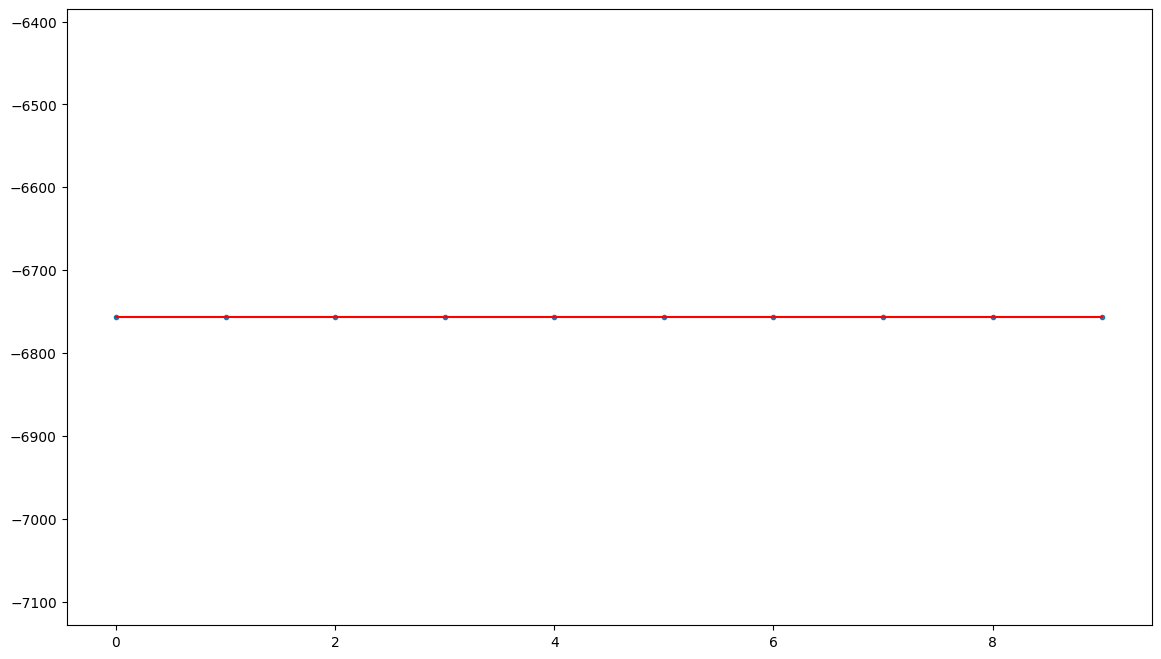

In [35]:


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=10000):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5

    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
       
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## 3) Problem instance with:
- UNIVERSE_SIZE = 10000
- NUM_SETS = 1000
- DENSITY = 0.2
- STEPS = 10000

In [36]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [37]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Random Mutation Hill Climbing

In [38]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [39]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-4276646.573873978))
ic| fitness(solution): (np.True_, np.float64(-137471.61677116633))


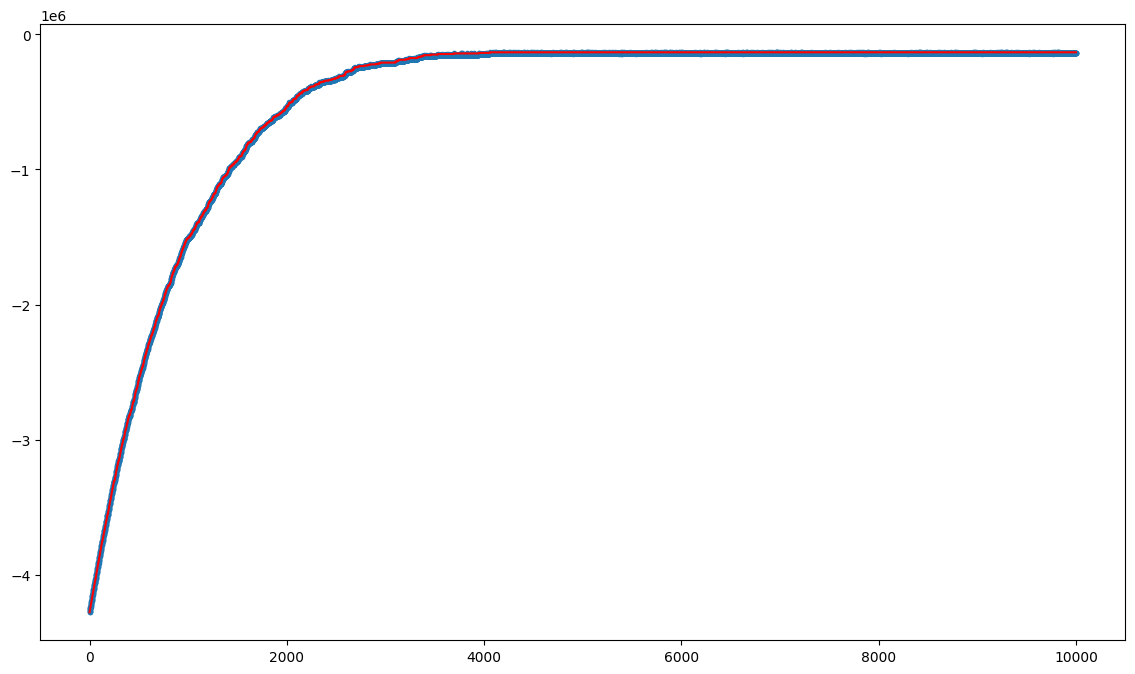

In [40]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [41]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-4276646.573873978))
ic| fitness(solution): (np.True_, np.float64(-566343.4972136455))


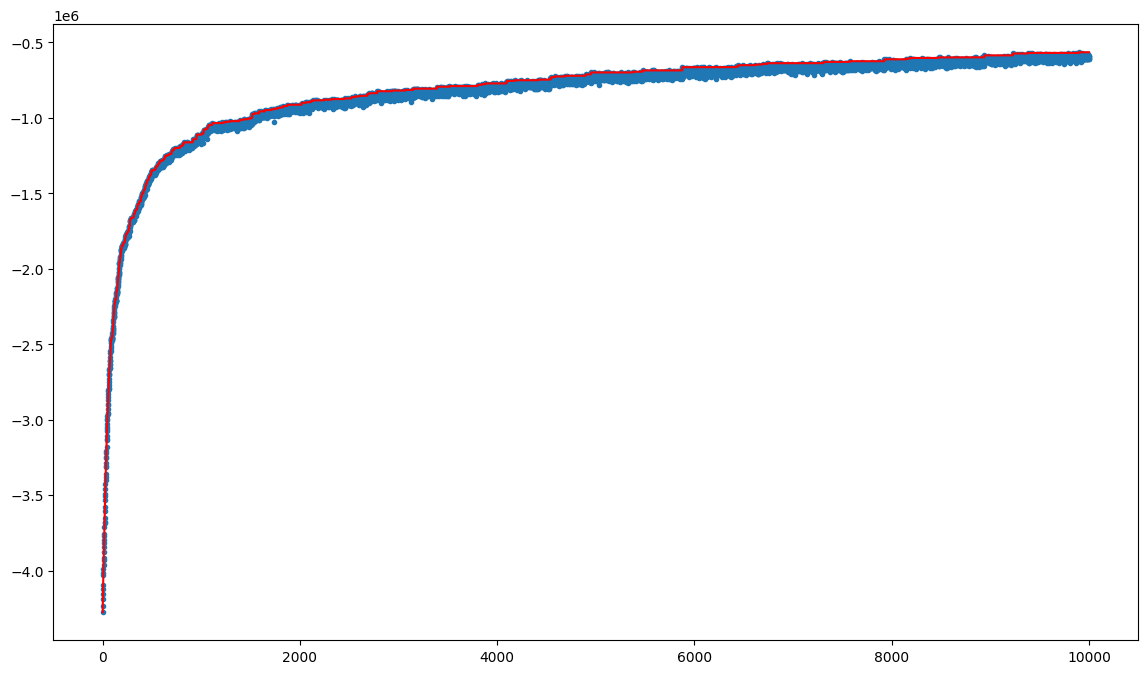

In [42]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(10000):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [43]:
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-4276646.573873978))
ic| fitness(solution): (np.True_, np.float64(-127774.83712610643))


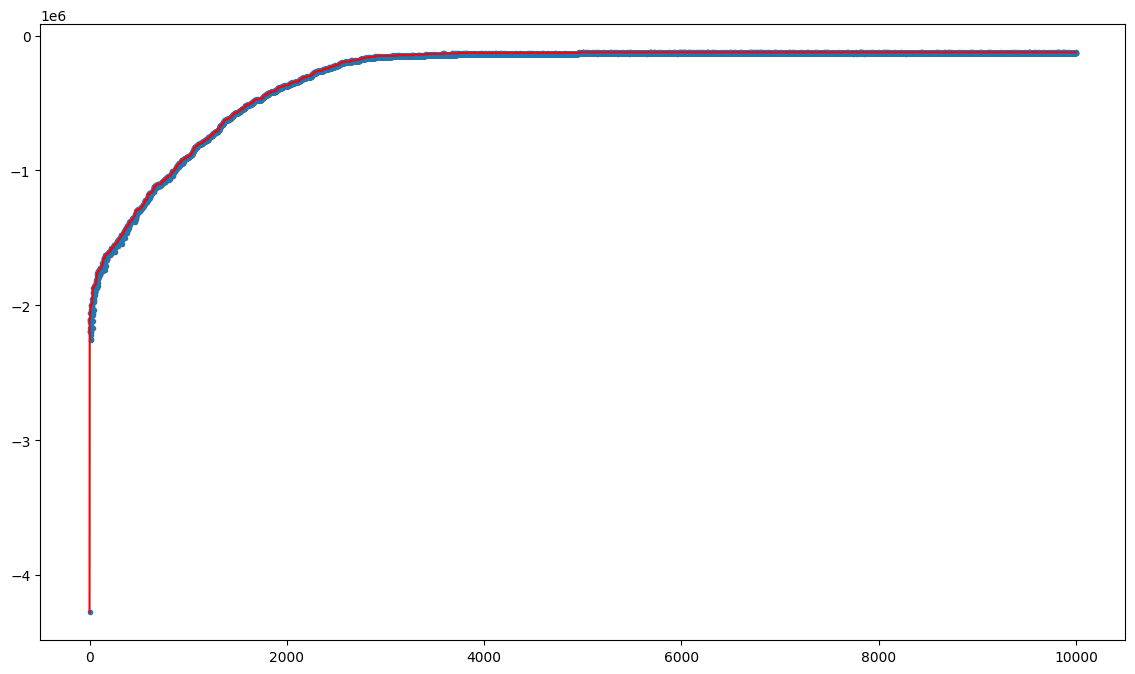

In [44]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(10000):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-4276646.573873978))
ic| fitness(solution): (np.True_, np.float64(-529077.4132525552))


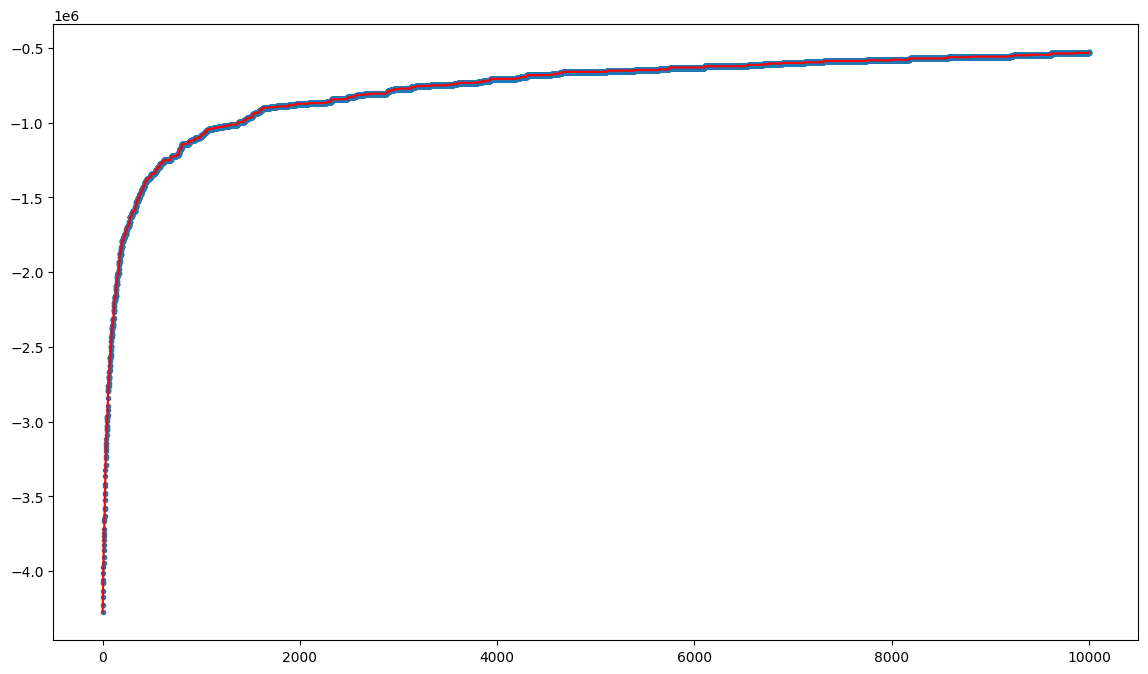

In [45]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995  
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]] 

temperature = INITIAL_TEMPERATURE

for steps in range(10000):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-249379.3188633203))


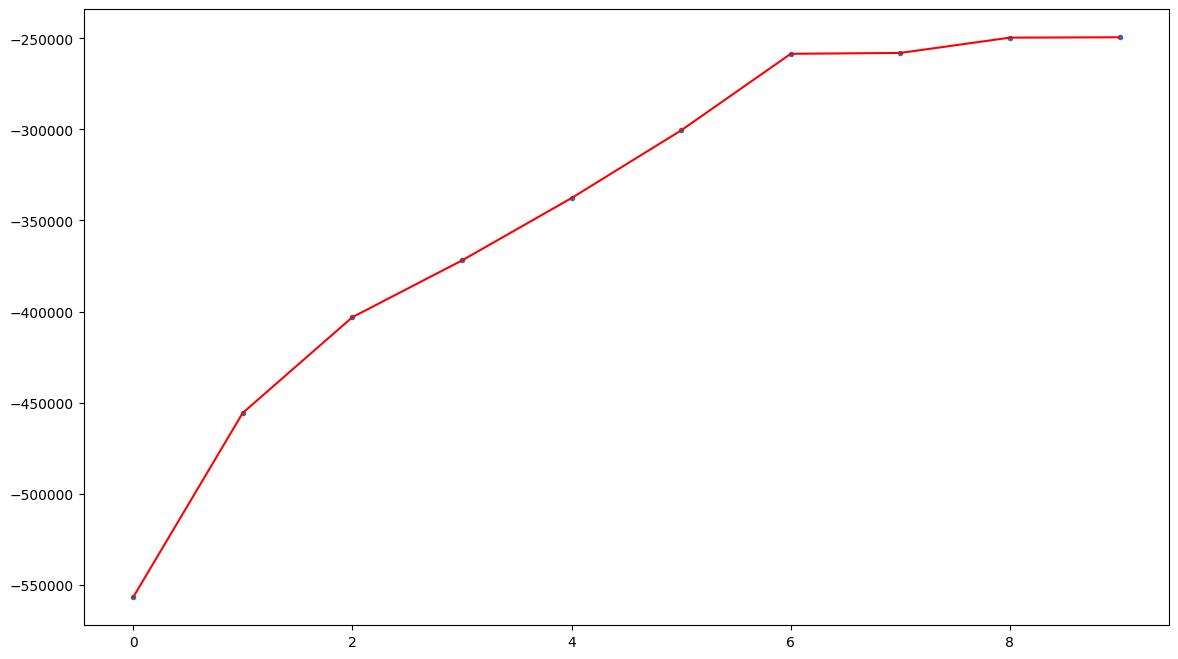

In [46]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=10000):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness


num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []


for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-223461.07190274898))


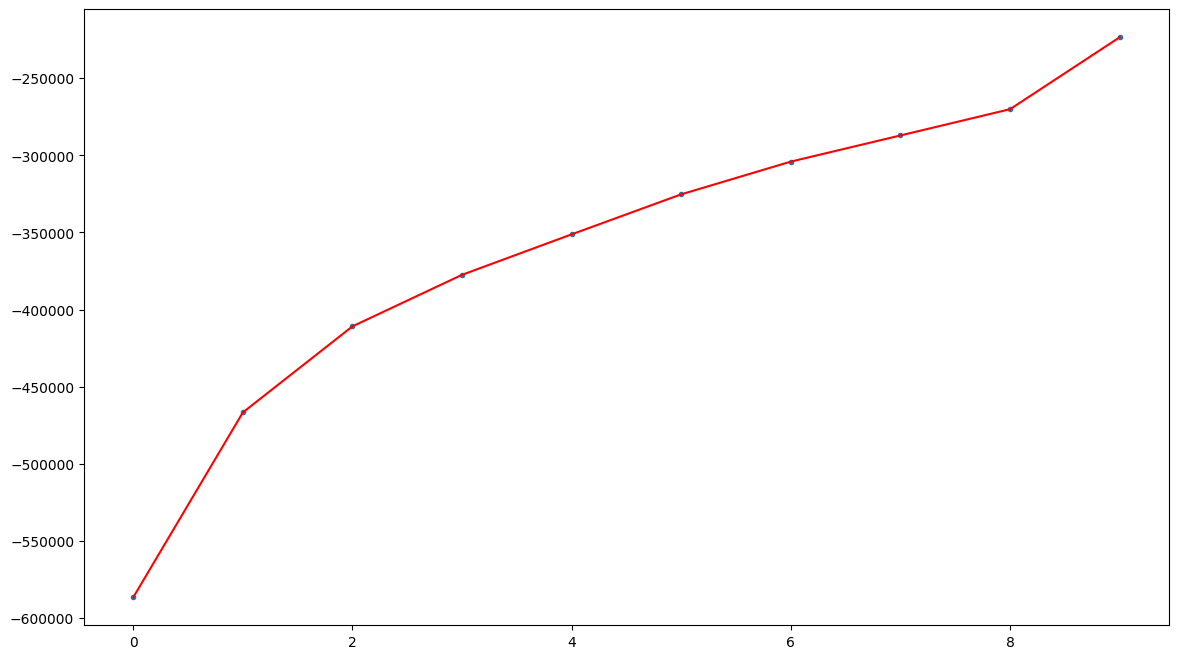

In [47]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=10000):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-566268.4382027364))


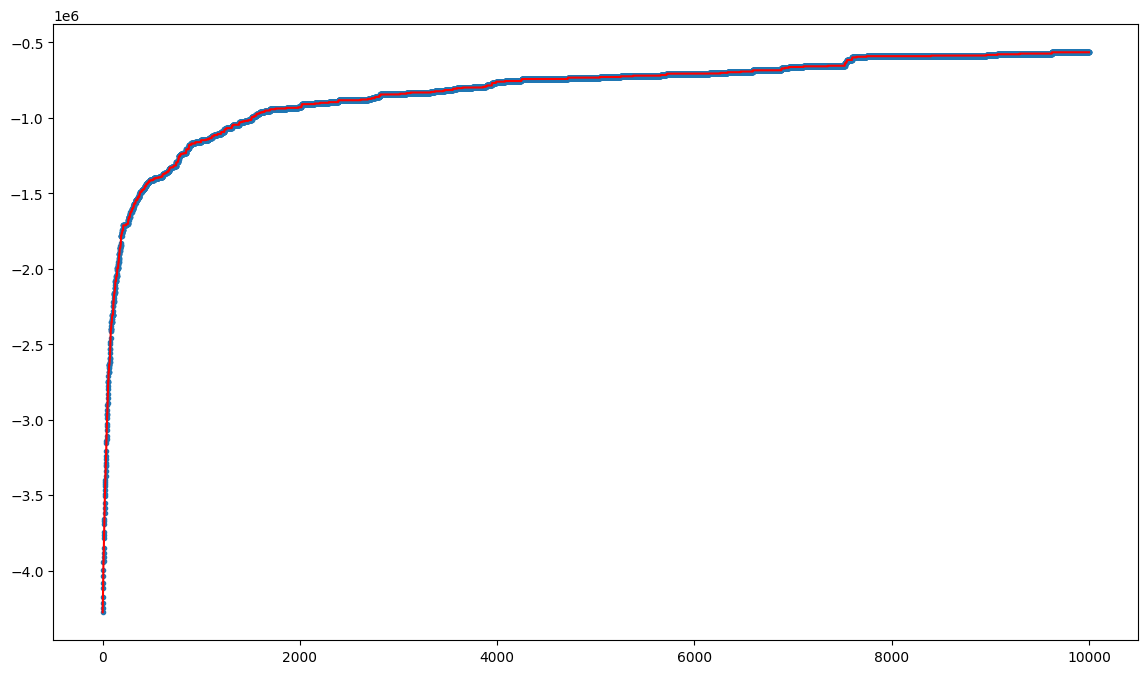

In [48]:

from collections import deque


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-232552.66563061884))


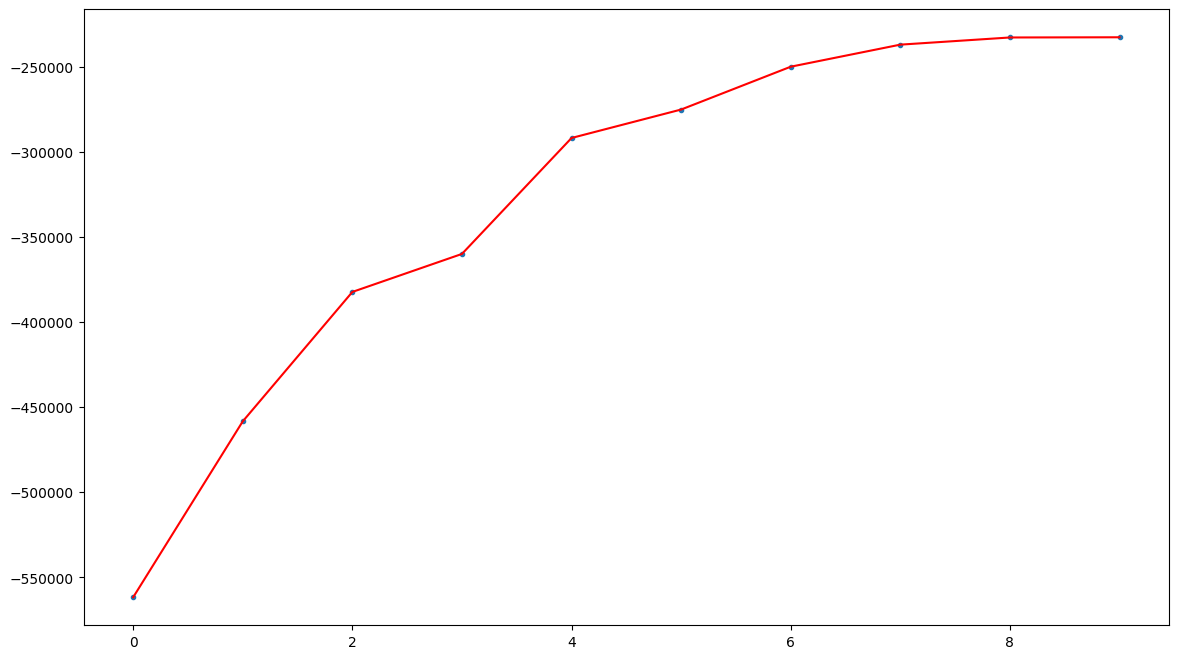

In [49]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=10000):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-1996019.4795676982))


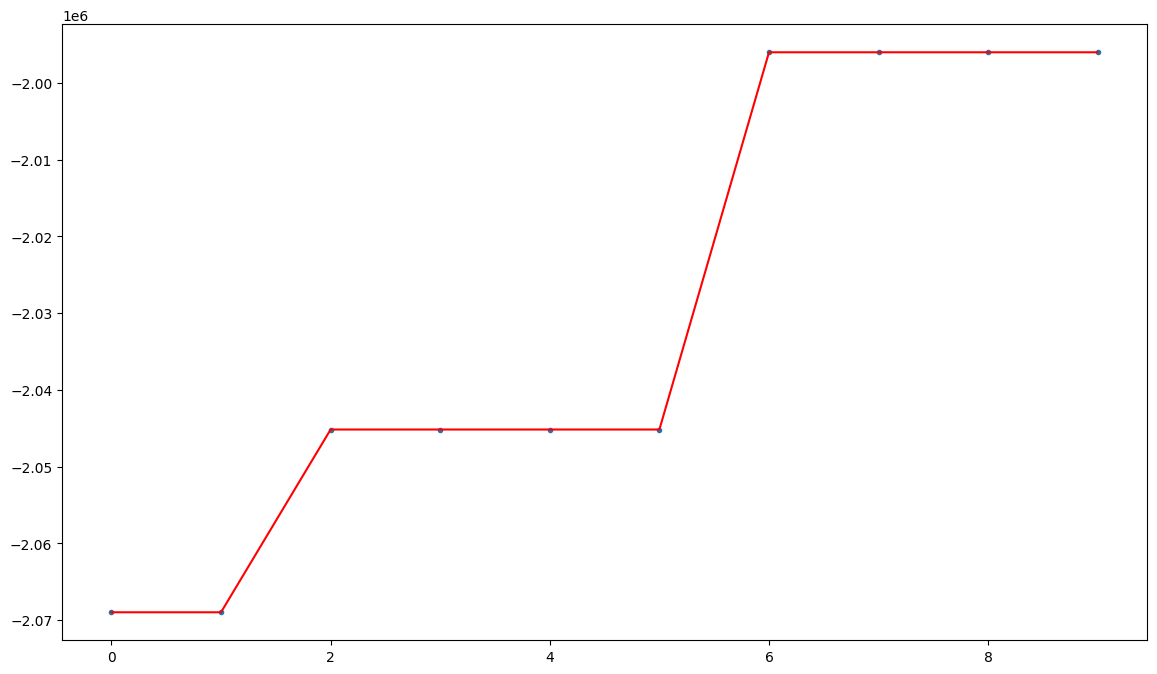

In [50]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def local_search(solution, max_steps=10000):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
     
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## 4) Problem instance with:
- UNIVERSE_SIZE = 100000
- NUM_SETS = 10000
- DENSITY = 0.1
- STEPS = 100

In [51]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [52]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Random Mutation Hill Climbing

In [53]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [54]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-251193966.73381135))
ic| fitness(solution): (np.True_, np.float64(-248683563.6831255))


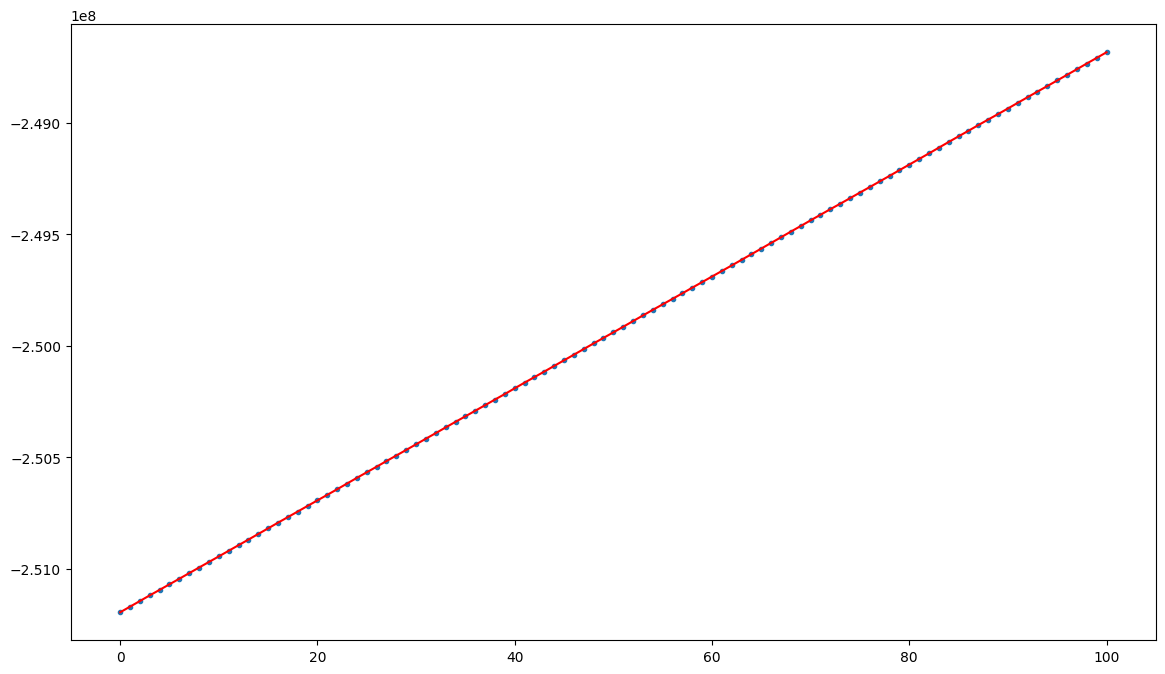

In [55]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [56]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-251193966.73381135))
ic| fitness(solution): (np.True_, np.float64(-141784378.00456095))


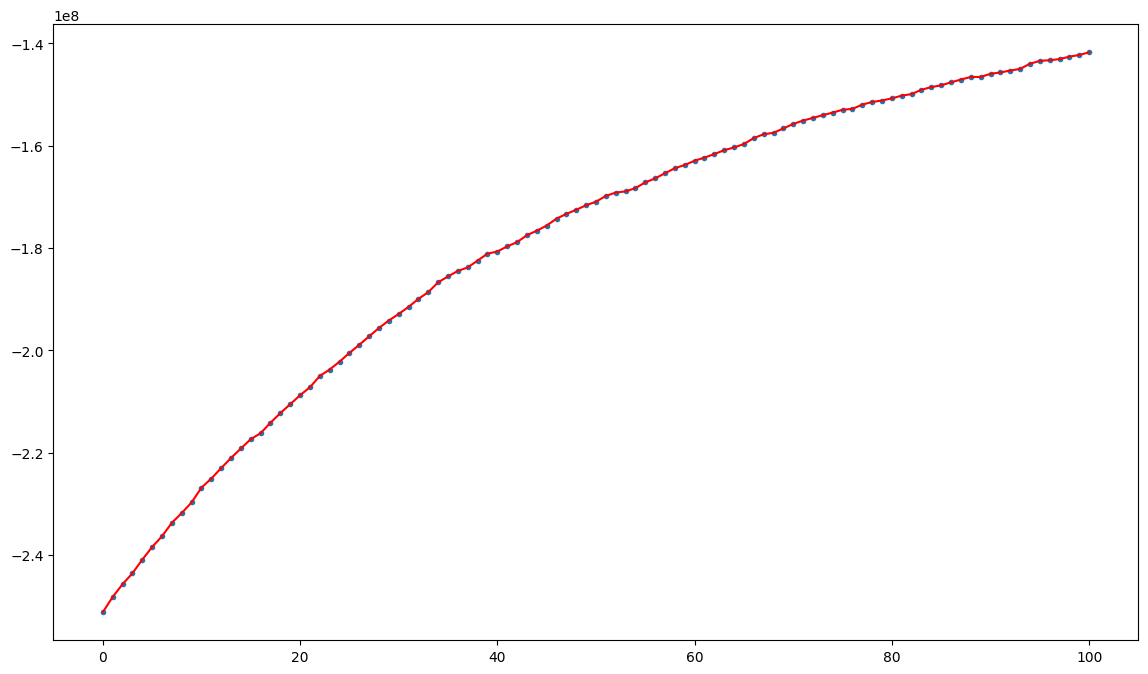

In [57]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [58]:
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-251193966.73381135))
ic| fitness(solution): (np.True_, np.float64(-117747305.64894632))


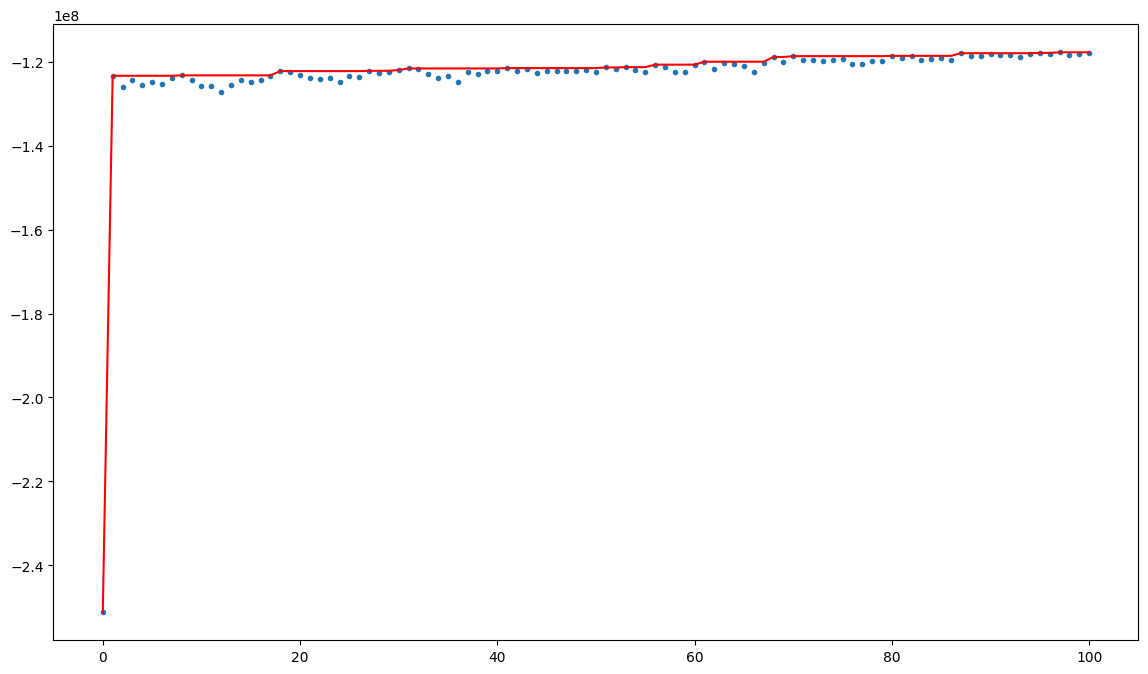

In [59]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(100):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-251193966.73381135))
ic| fitness(solution): (np.True_, np.float64(-142499842.30063236))


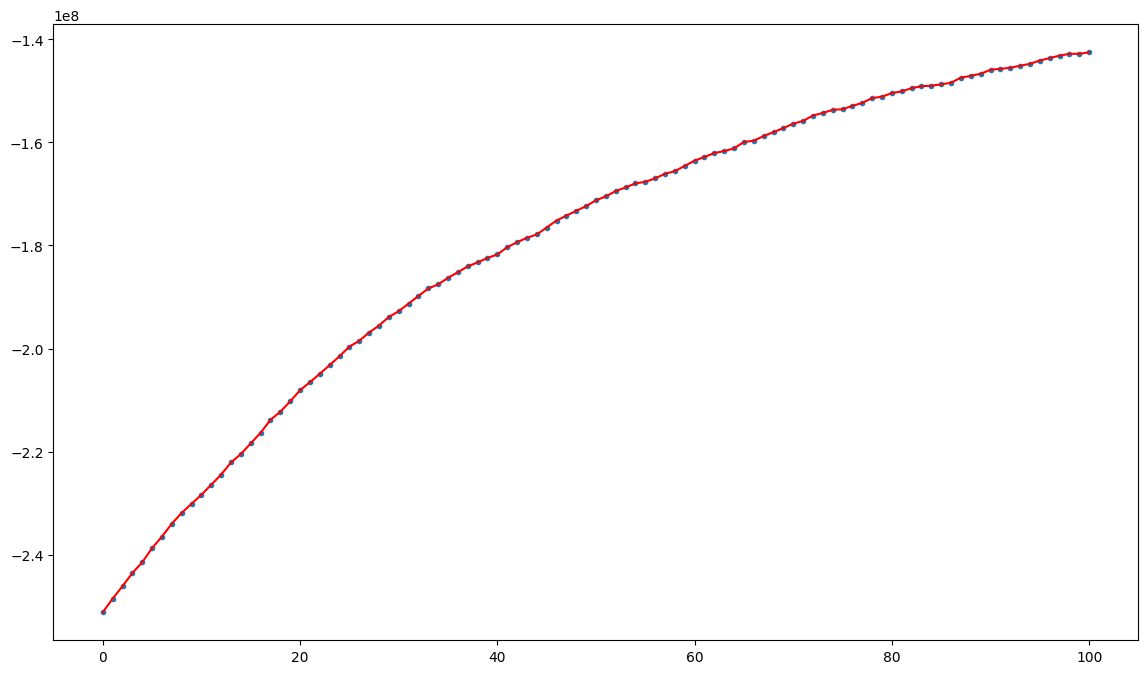

In [60]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995  
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]] 

temperature = INITIAL_TEMPERATURE

for steps in range(100):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-106443966.97096014))


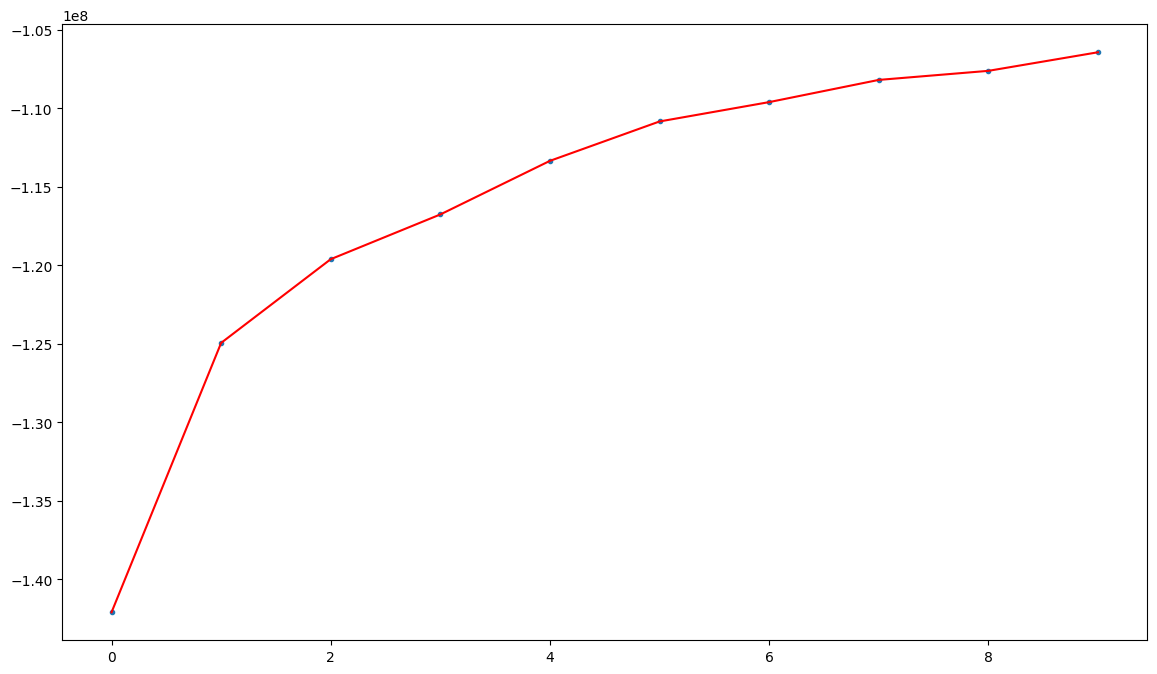

In [61]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=100):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness


num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []


for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-106397132.40097389))


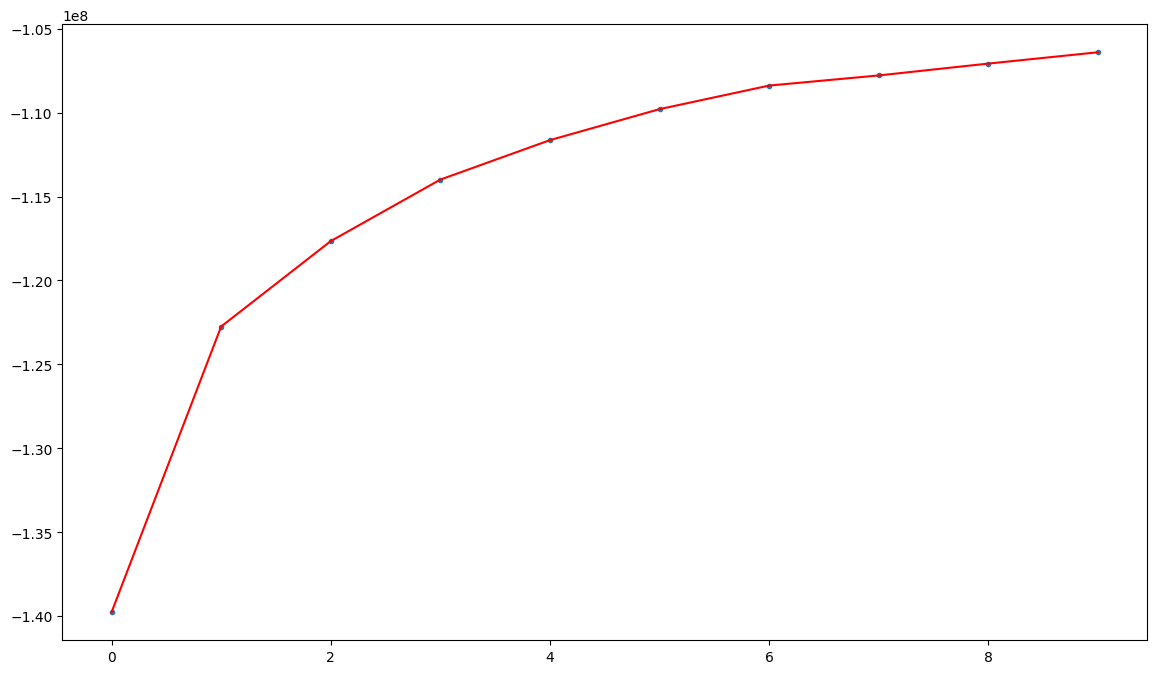

In [62]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=100):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-142282535.23189875))


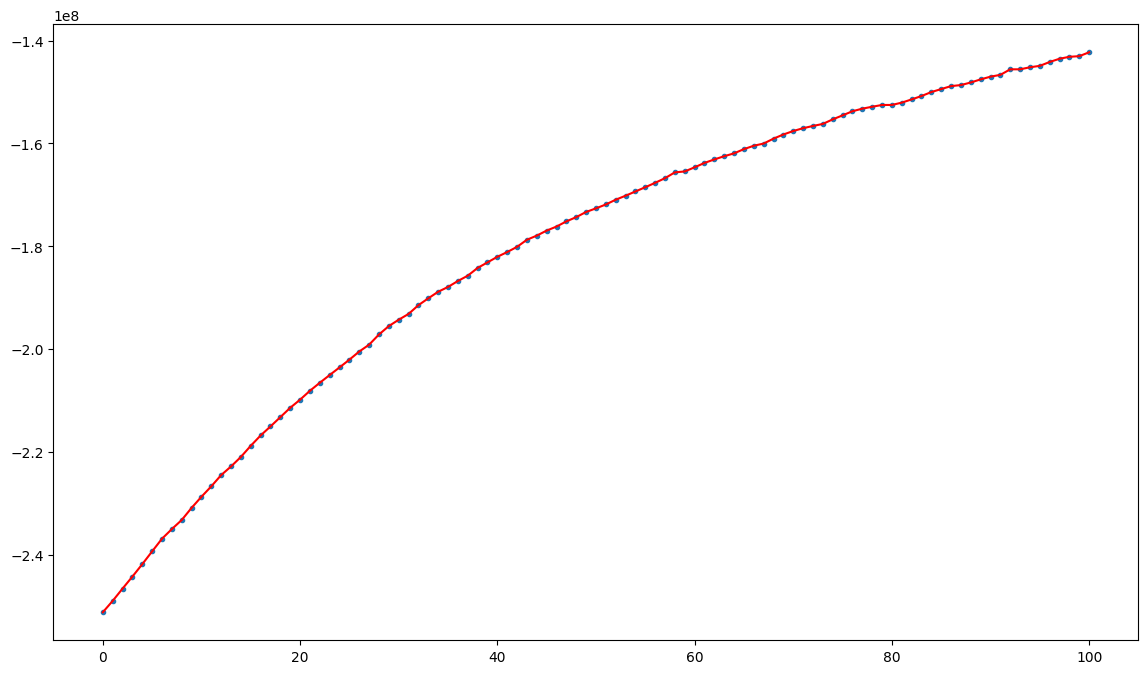

In [63]:

from collections import deque


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-106014254.60375178))


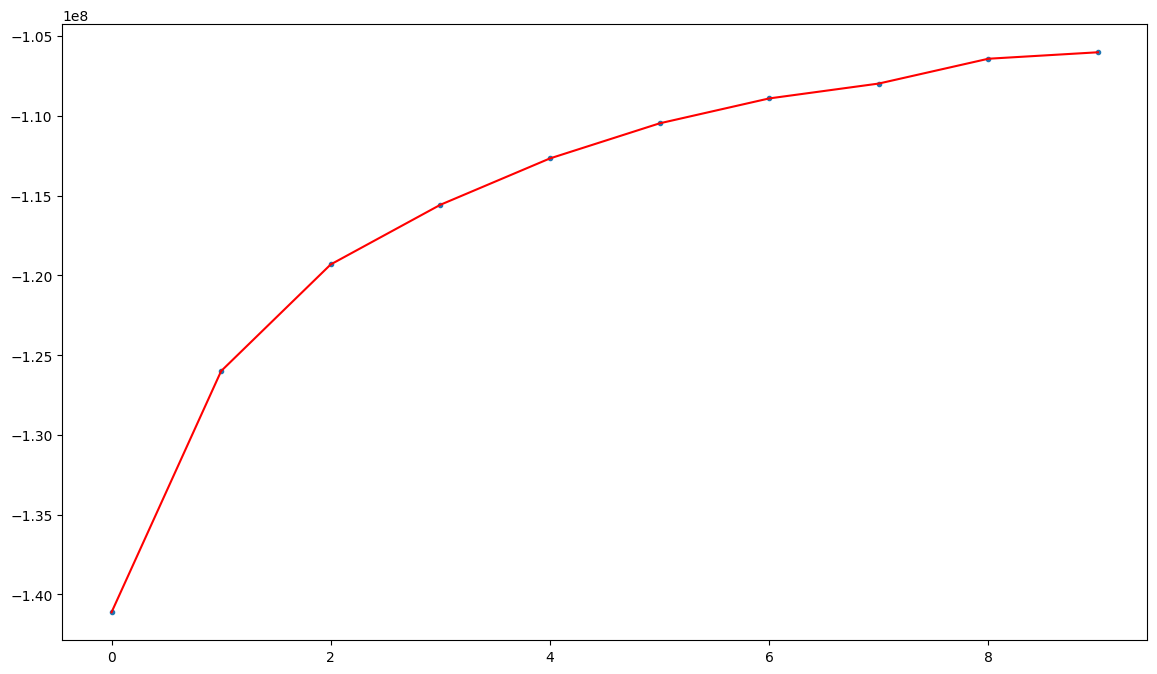

In [64]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-120553547.07959163))


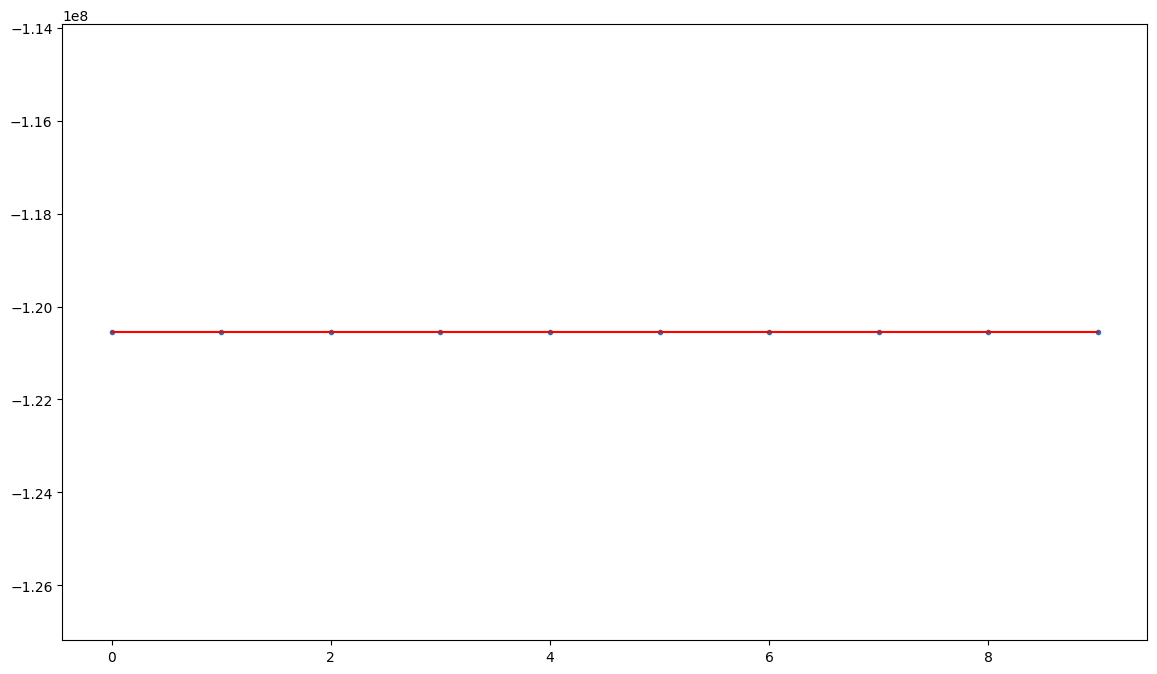

In [65]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def local_search(solution, max_steps=100):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
     
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## 5) Problem instance with:
- UNIVERSE_SIZE = 100000
- NUM_SETS = 10000
- DENSITY = 0.2
- STEPS = 100

In [66]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [67]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Random Mutation Hill Climbing

In [68]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [69]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-538339606.7932858))
ic| fitness(solution): (np.True_, np.float64(-532954909.16157806))


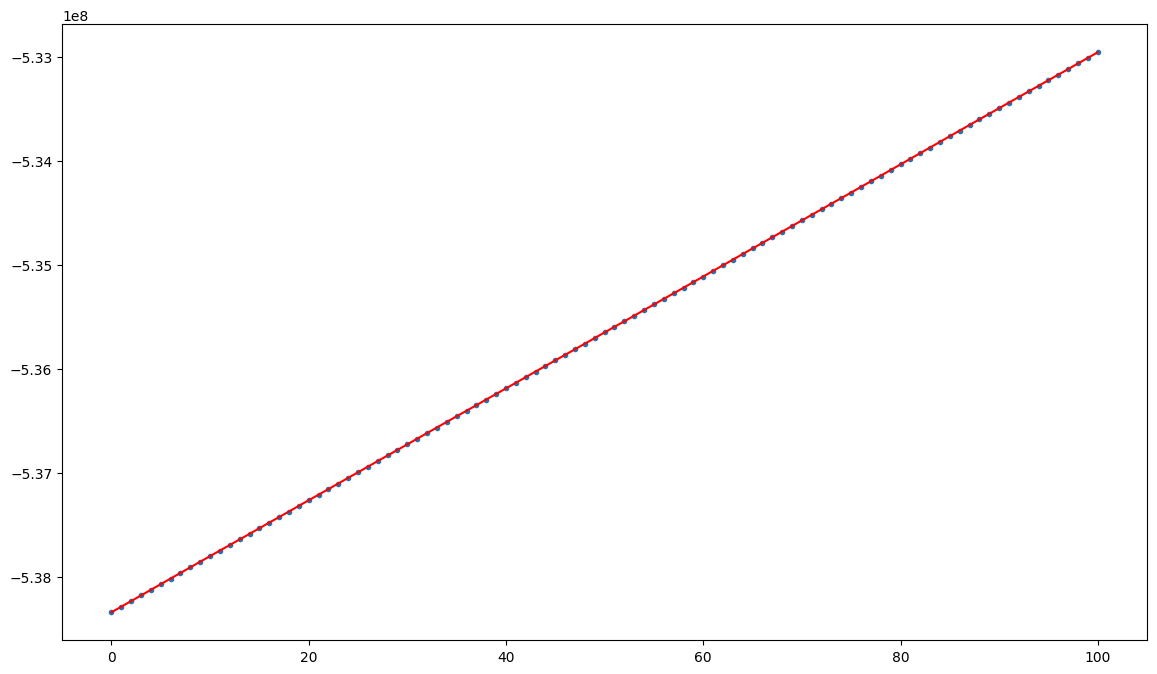

In [70]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [71]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-538339606.7932858))
ic| fitness(solution): (np.True_, np.float64(-306361700.8459194))


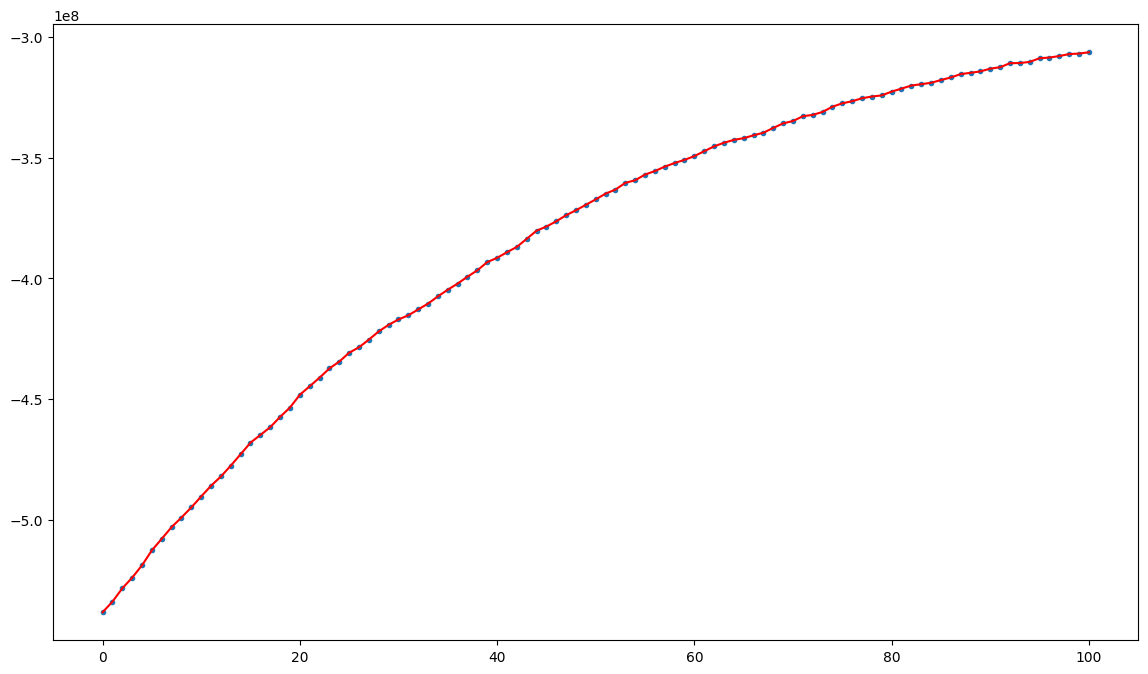

In [72]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [73]:
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-538339606.7932858))
ic| fitness(solution): (np.True_, np.float64(-253807385.4652709))


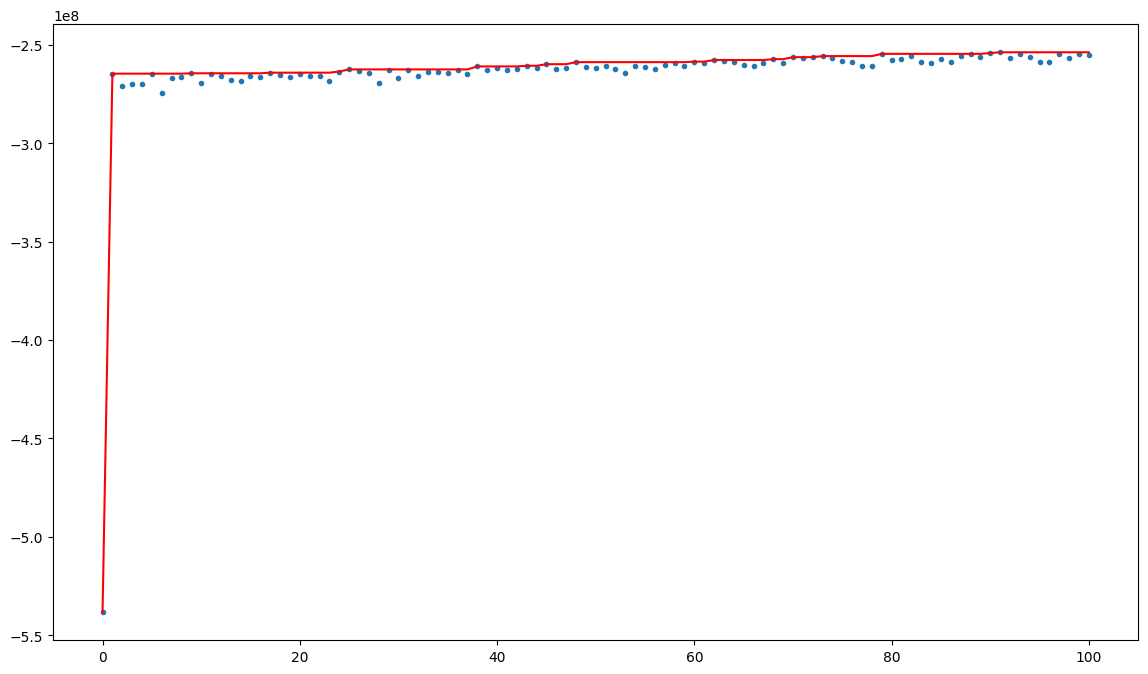

In [74]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(100):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-538339606.7932858))
ic| fitness(solution): (np.True_, np.float64(-303979504.58464193))


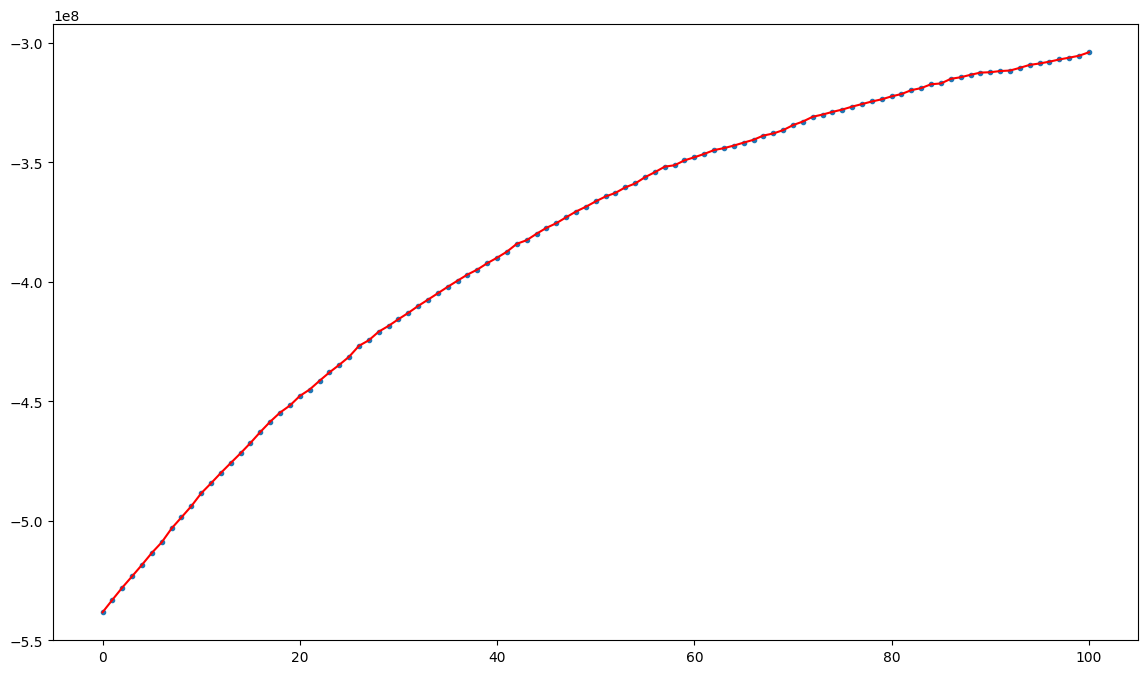

In [75]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995  
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]] 

temperature = INITIAL_TEMPERATURE

for steps in range(100):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-230595999.6883095))


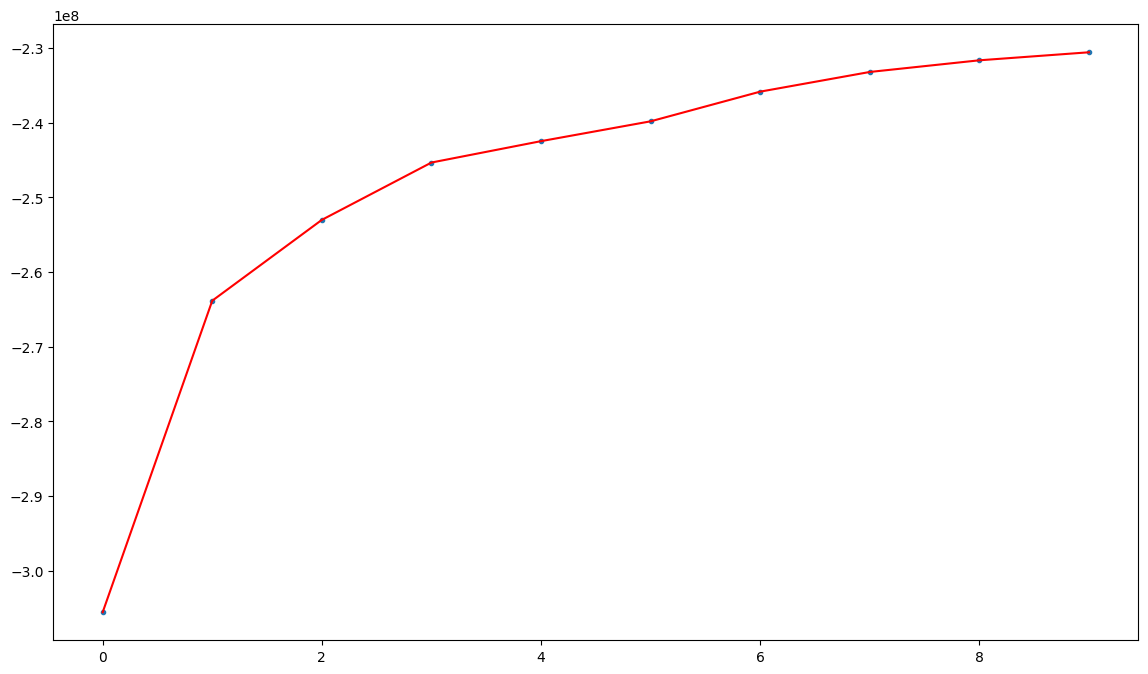

In [76]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=100):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness


num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []


for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-228945872.29505128))


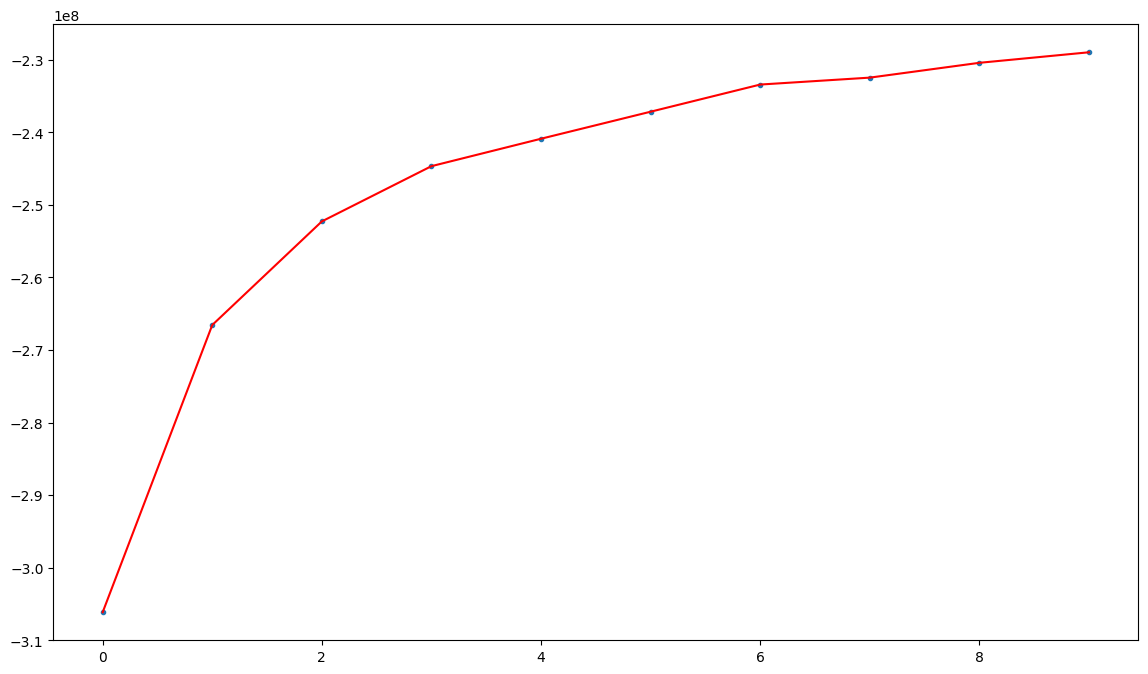

In [77]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=100):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-303986026.14713734))


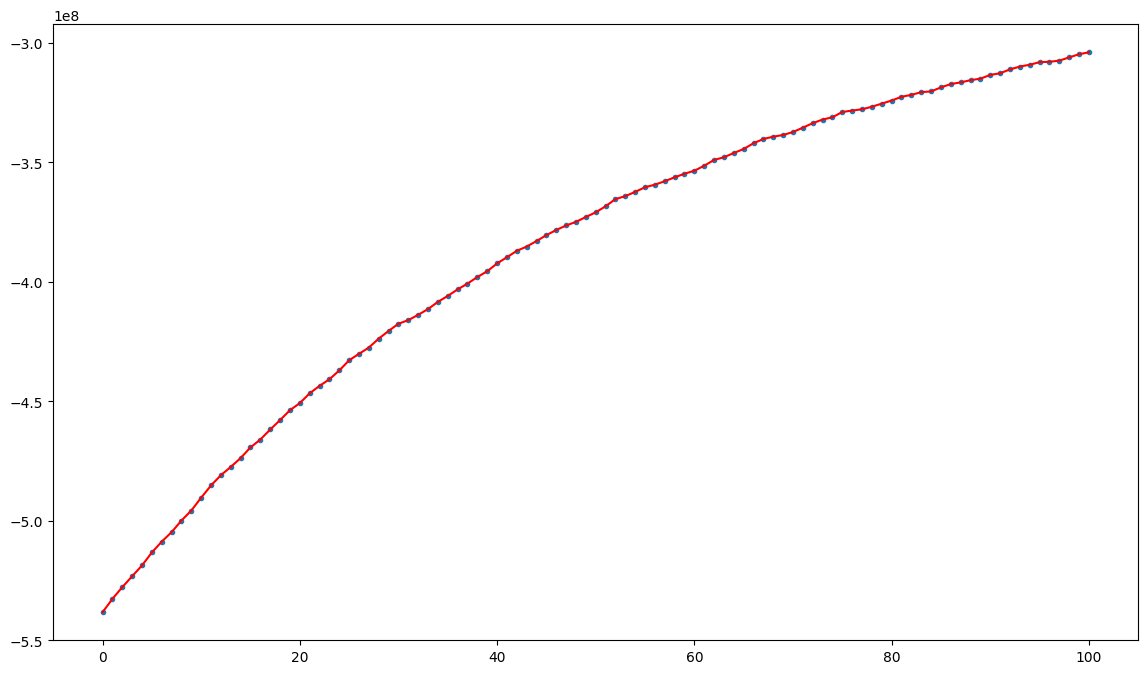

In [78]:

from collections import deque


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-228223203.5790813))


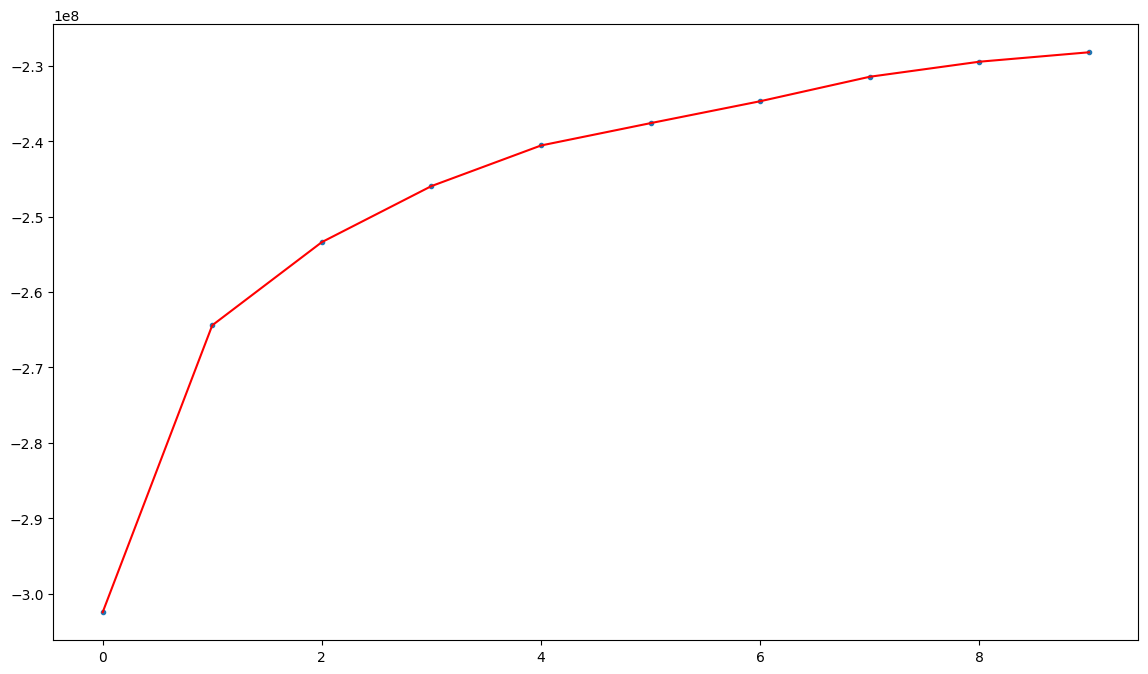

In [79]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-261744732.05230793))


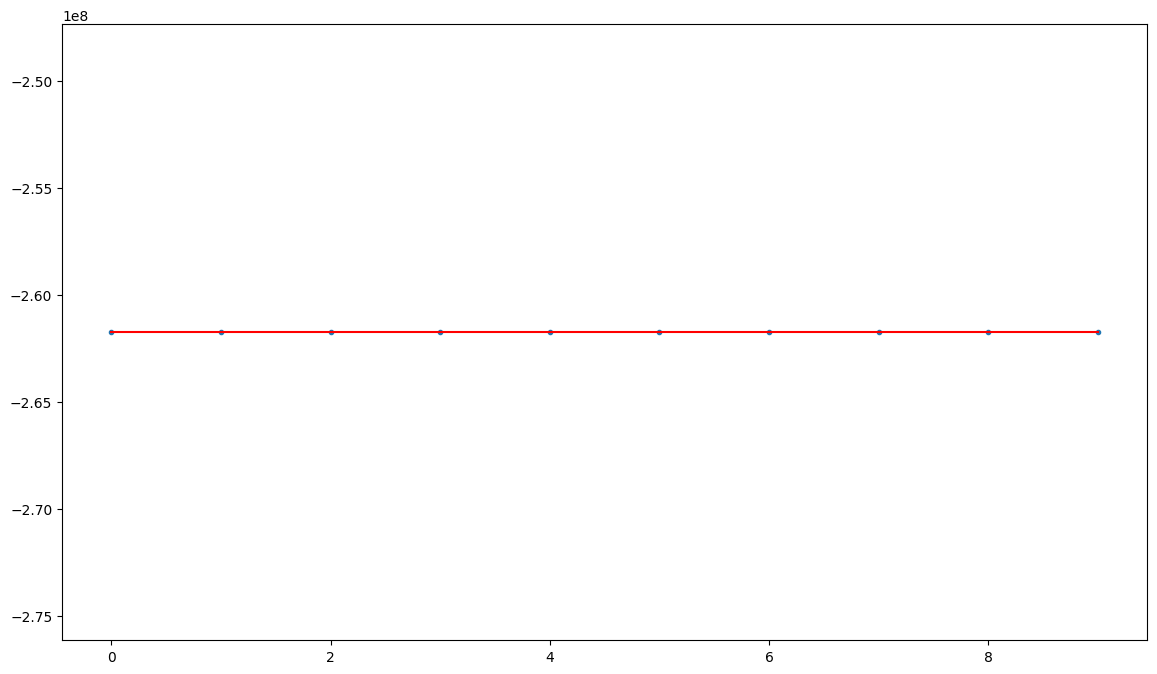

In [80]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def local_search(solution, max_steps=100):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
     
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## 6) Problem instance with:
- UNIVERSE_SIZE = 100000
- NUM_SETS = 10000
- DENSITY = 0.3
- STEPS = 100

In [81]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [82]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Random Mutation Hill Climbing

In [83]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol


In [84]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

ic| fitness(solution): (np.True_, np.float64(-841000583.7258847))
ic| fitness(solution): (np.True_, np.float64(-832588355.6655387))


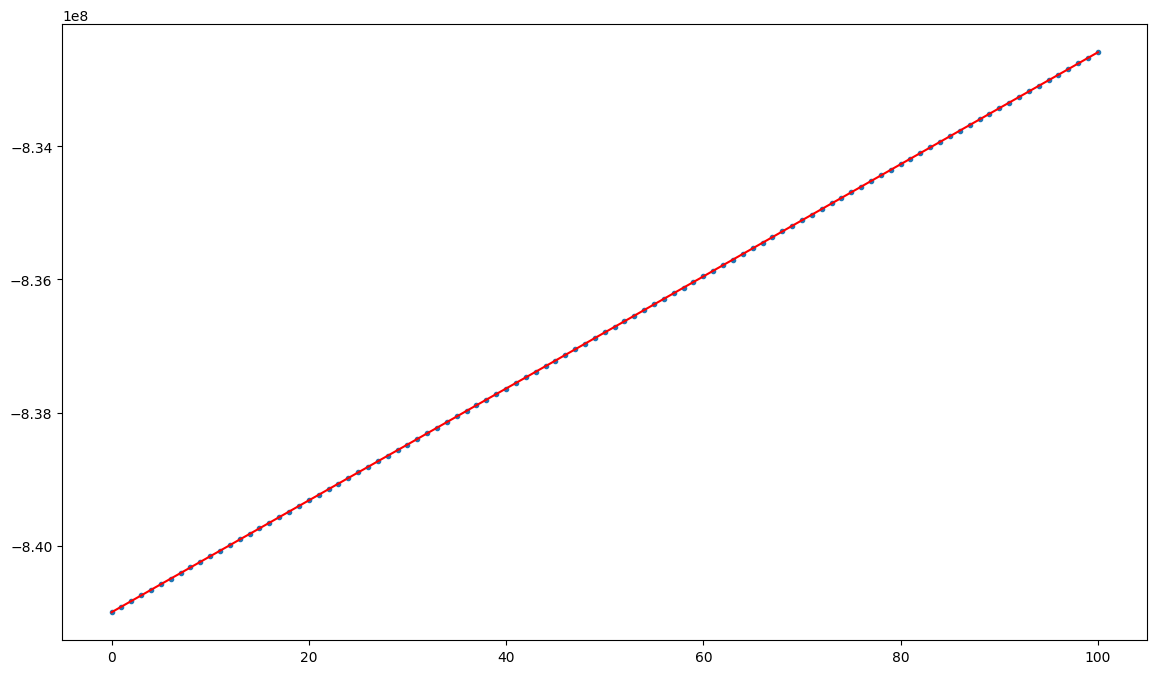

In [85]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak

In [86]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-841000583.7258847))
ic| fitness(solution): (np.True_, np.float64(-479401237.22485375))


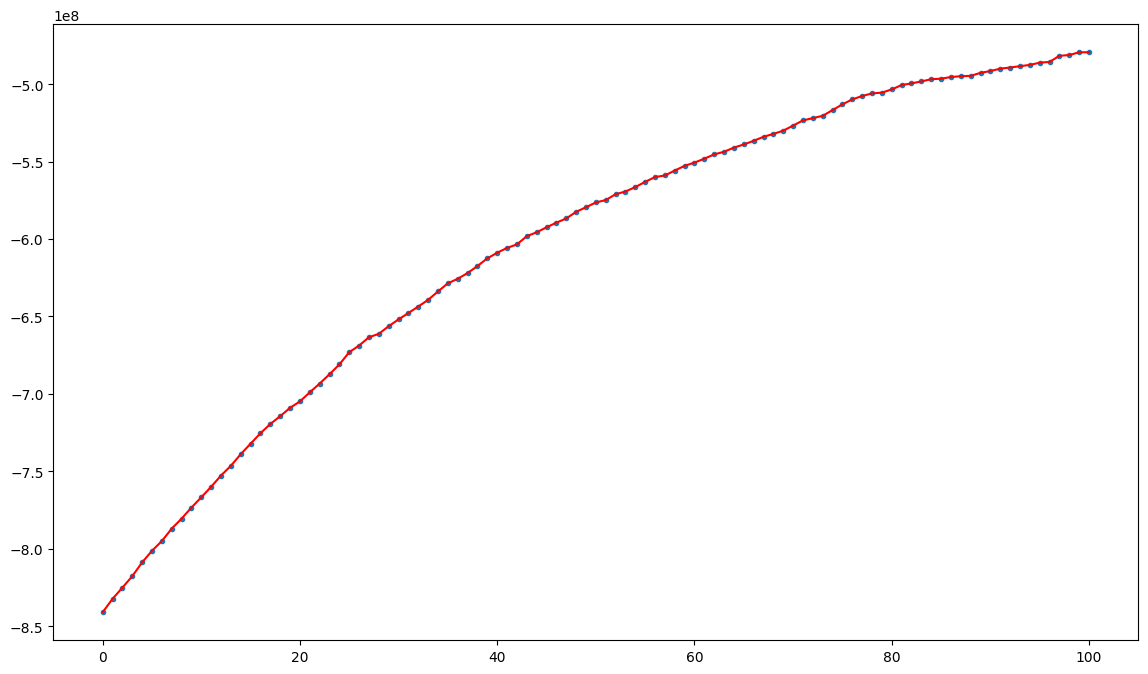

In [87]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]] 
ic(fitness(solution))

for steps in range(100):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Hill Climbing with a more powerful tweak and 1 out of 5 rule

In [88]:
def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol

ic| fitness(solution): (np.True_, np.float64(-841000583.7258847))
ic| fitness(solution): (np.True_, np.float64(-407089658.22214735))


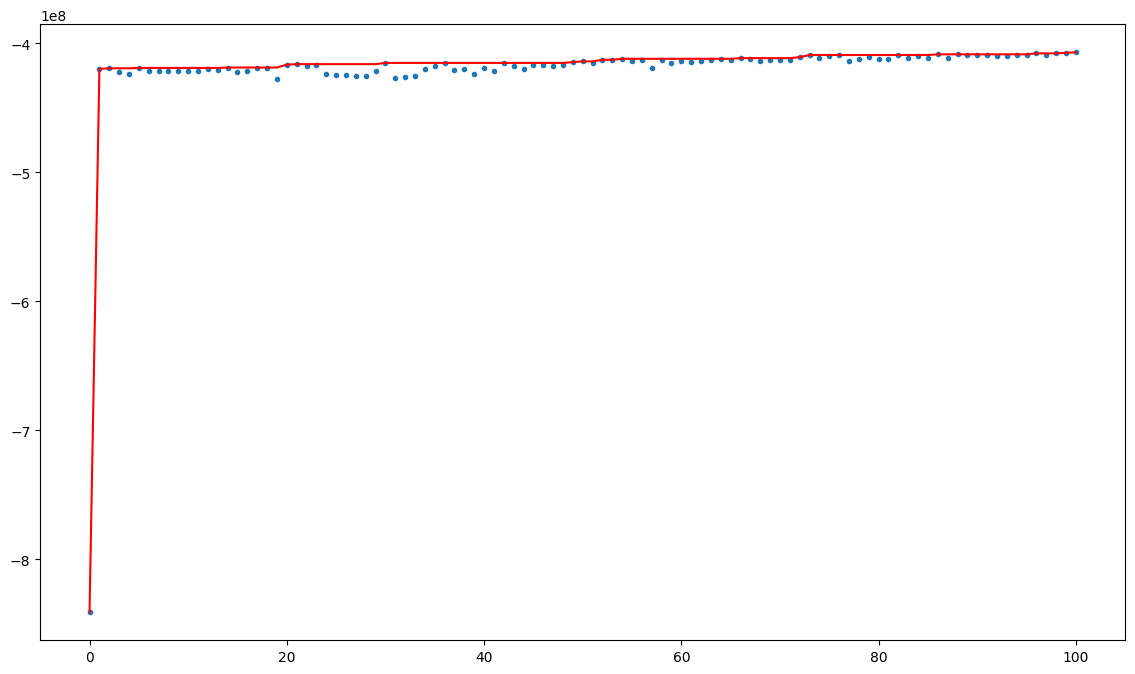

In [89]:
BUFFER_SIZE = 5

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()
for steps in range(100):
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]

    if sum(buffer) > 1:
        strength *= 1.2
    elif sum(buffer) == 0:
        strength /= 1.2

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-841000583.7258847))
ic| fitness(solution): (np.True_, np.float64(-473595486.8980559))


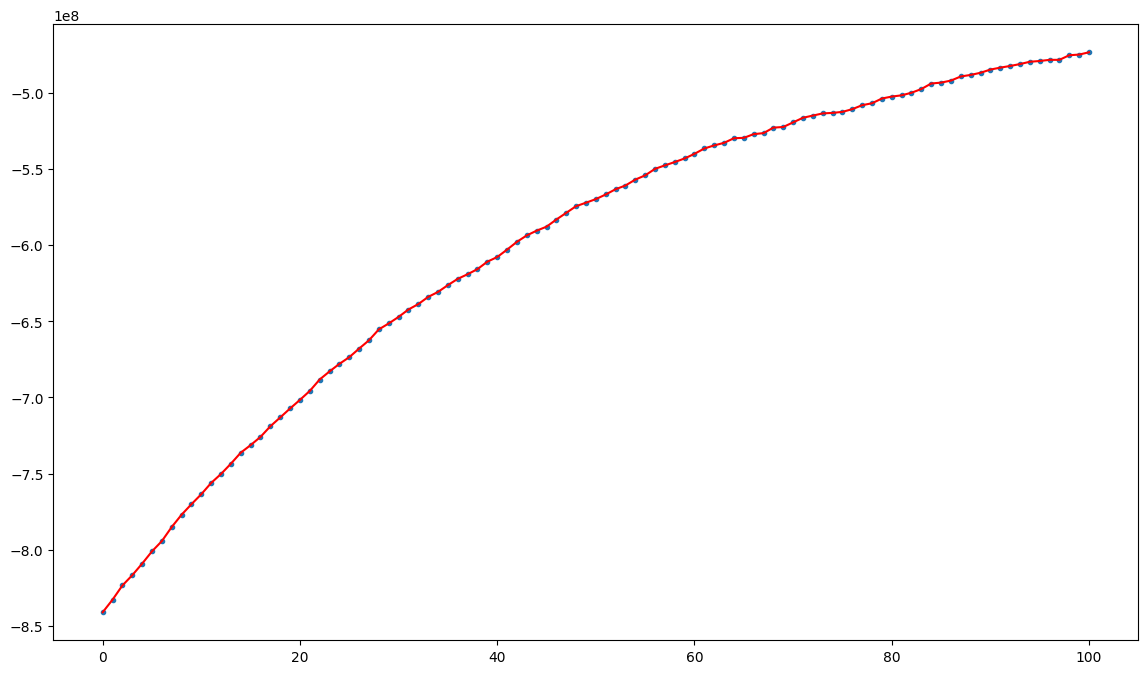

In [90]:
INITIAL_TEMPERATURE = 1000  
COOLING_RATE = 0.995  
MIN_TEMPERATURE = 1e-4  

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(fitness(solution))
history = [solution_fitness[1]] 

temperature = INITIAL_TEMPERATURE

for steps in range(100):
    #if temperature <= MIN_TEMPERATURE:
    #    break

    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)

    delta_fitness_cost = new_fitness[1] - solution_fitness[1]

    """if new_fitness <= solution_fitness:
        temperature *= COOLING_RATE
        history.append(solution_fitness[1])
        continue"""

    if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
        solution = new_solution
        solution_fitness = new_fitness

    temperature *= COOLING_RATE

    history.append(solution_fitness[1])

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()

## Iterated Local Search

ic| best_global_fitness: (True, np.float64(-360354784.75915027))


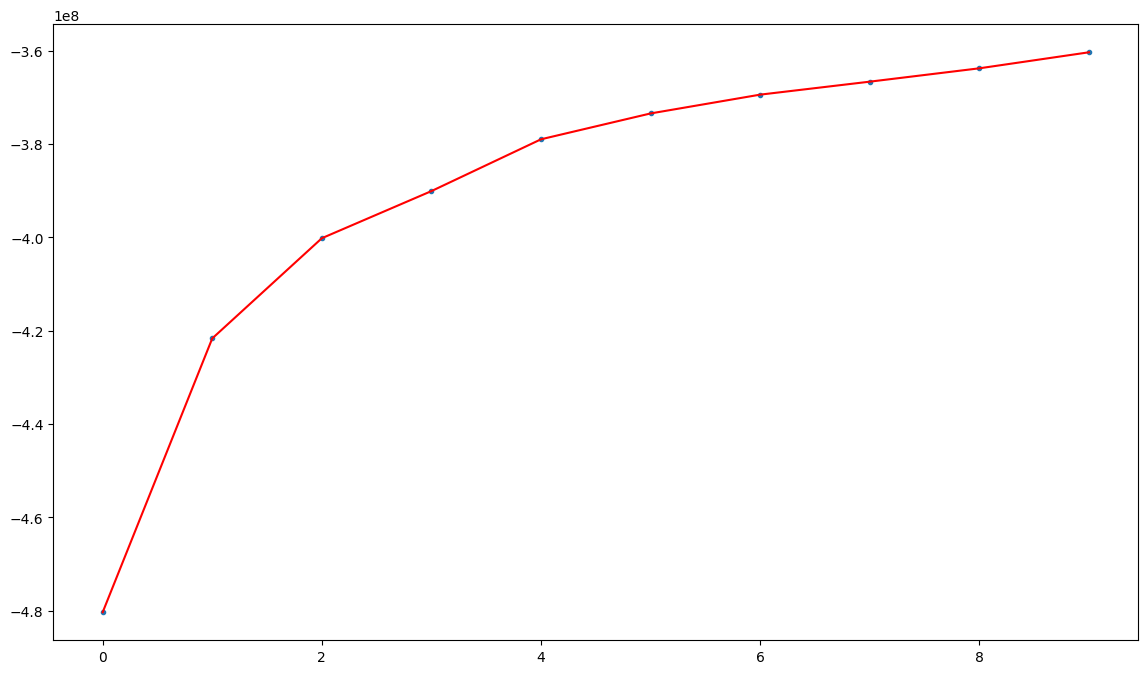

In [91]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def local_search(solution, max_steps=100):
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness


num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []


for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Iterated Local Search with Simulated Annealing

ic| best_global_fitness: (True, np.float64(-352696522.9560667))


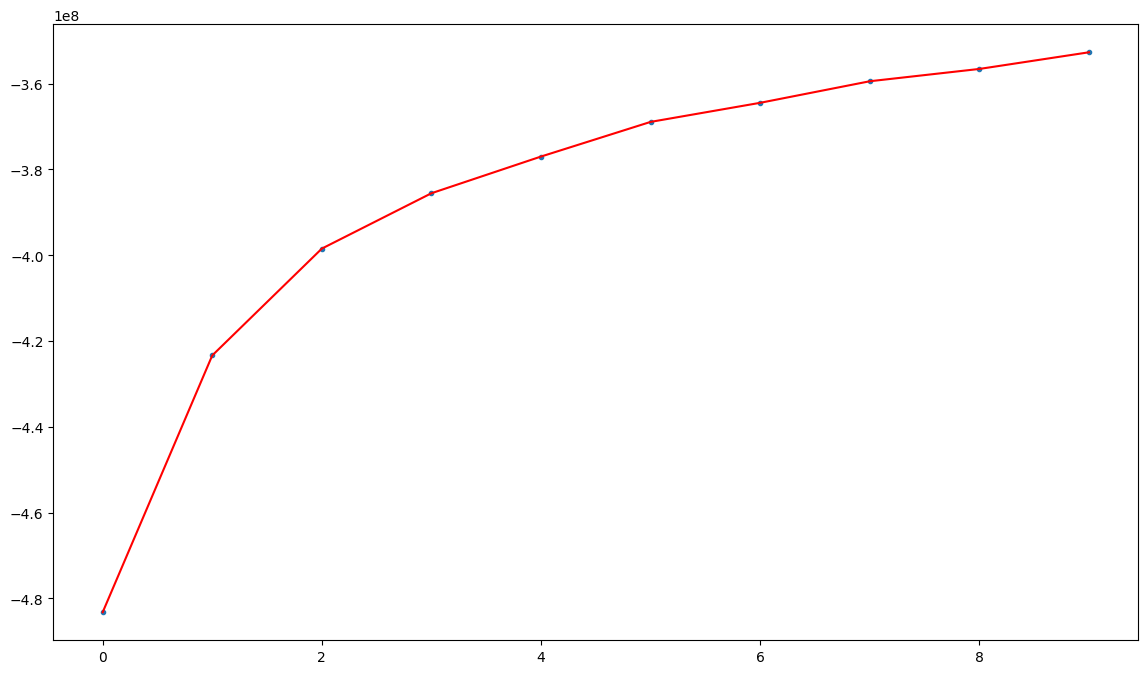

In [92]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def simulated_annealing(solution, initial_temperature=1000, cooling_rate=0.995, min_temperature=1e-4, max_steps=100):
    temperature = initial_temperature
    current_solution = solution
    current_fitness = fitness(current_solution)

    for step in range(max_steps):
        #if temperature <= min_temperature:
        #    break

        new_solution = multiple_mutation(current_solution)
        new_fitness = fitness(new_solution)

        delta_fitness_cost = new_fitness[1] - current_fitness[1]

        """if new_fitness <= solution_fitness:
            temperature *= COOLING_RATE
            continue"""

        if delta_fitness_cost > 0 or np.exp(delta_fitness_cost / temperature) > rng.random():
            current_solution = new_solution
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = simulated_annealing(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Tabu Search

ic| best_fitness: (True, np.float64(-478785751.70862997))


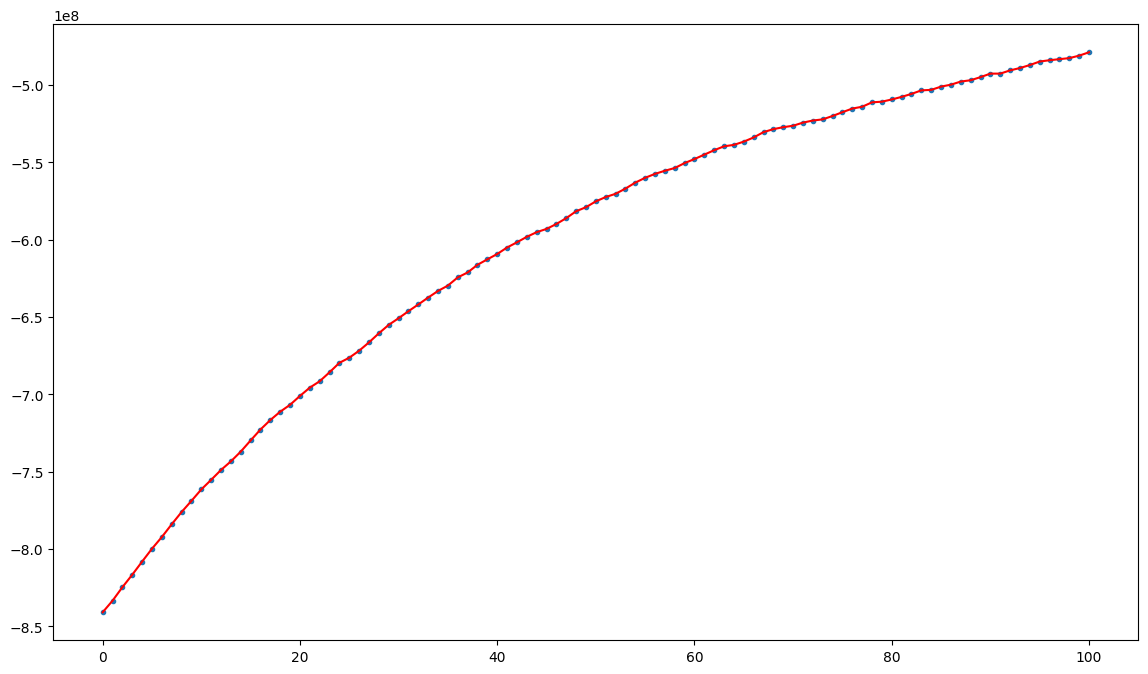

In [93]:

from collections import deque


def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask) 
    return new_sol

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    history = [current_fitness[1]]
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        
        history.append(best_fitness[1])
    
    return best_solution, best_fitness, history

initial_solution = rng.random((NUM_SETS,)) < 1

best_solution, best_fitness, history = tabu_search(initial_solution)

ic(best_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


## Local Iterated Search with Tabu Search

ic| best_global_fitness: (True, np.float64(-361801423.8139957))


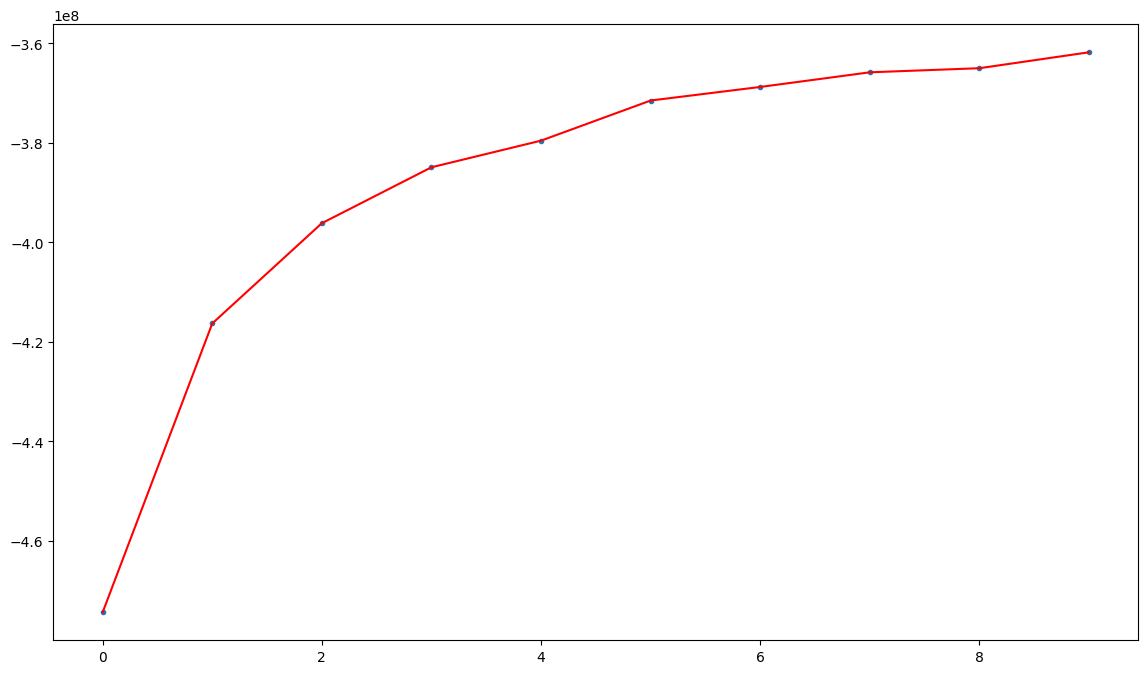

In [94]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf'))  
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01  
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_  

def tabu_search(initial_solution, tabu_tenure=10, max_iterations=100):
    current_solution = initial_solution
    current_fitness = fitness(current_solution)
    
    best_solution = current_solution
    best_fitness = current_fitness
    
    tabu_list = deque(maxlen=tabu_tenure)
    
    for iteration in range(max_iterations):
        new_solution = multiple_mutation(current_solution)
        
        new_fitness = fitness(new_solution)
        
        if (new_solution.tolist() not in tabu_list) and (new_fitness > current_fitness):
            current_solution = new_solution
            current_fitness = new_fitness
            
            tabu_list.append(current_solution.tolist())
        
        if new_fitness > best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
    
    return best_solution, best_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = tabu_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()


# Local Iterated Search with 1 out 5 rule

ic| best_global_fitness: (True, np.float64(-360459151.1306795))


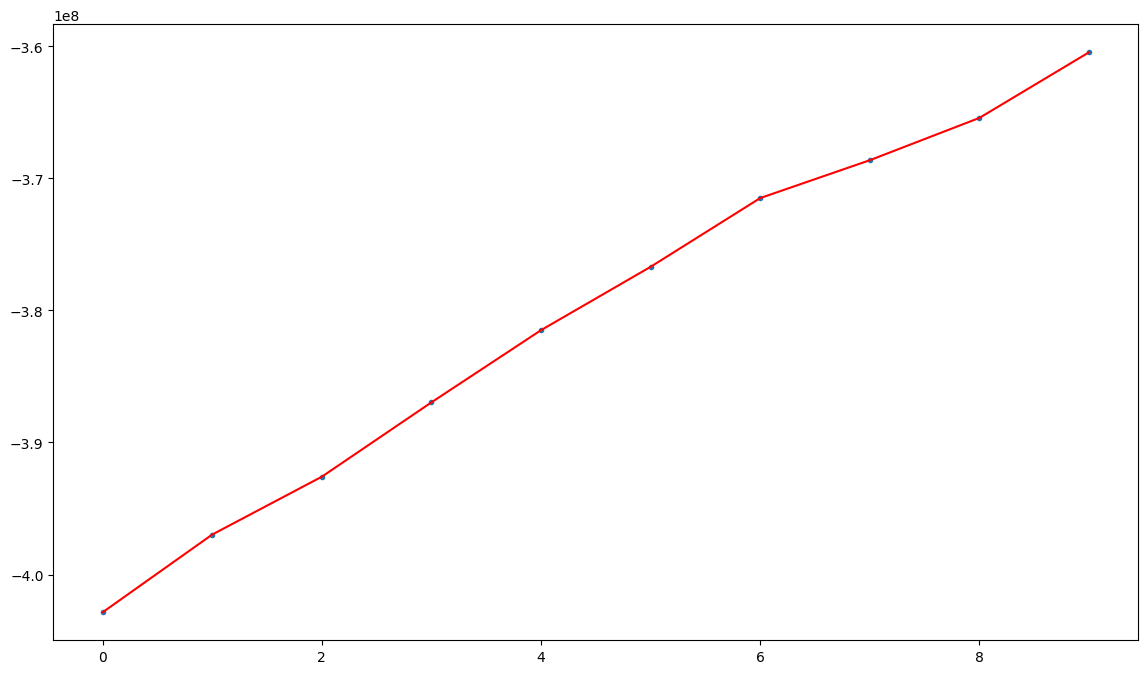

In [95]:
def valid(solution):
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    return COSTS[solution].sum()

def fitness(solution: np.ndarray):
    if not valid(solution):
        return (False, -float('inf')) 
    return (True, -cost(solution))

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < 0.01 
    new_sol = np.logical_xor(solution, mask)  
    return new_sol

def new_starting_position(global_, last):
    if global_ is None:
        return rng.random((NUM_SETS,)) < 1
    else:
        return global_ 

def local_search(solution, max_steps=100):
    BUFFER_SIZE = 5

    buffer = list()
    strength = 0.5
    current_solution = solution
    current_fitness = fitness(current_solution)
    
    for steps in range(max_steps):
        new_solution = multiple_mutation_strength(current_solution, strength)
        new_fitness = fitness(new_solution)

        buffer.append(f > solution_fitness)
        buffer = buffer[-BUFFER_SIZE:]
     
        if sum(buffer) > 1:
            strength *= 1.2
        elif sum(buffer) == 0:
            strength /= 1.2
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
    
    return current_solution, current_fitness

num_iterations = 10
best_global_solution = None
best_global_fitness = (False, -float('inf'))
history = []

for iteration in range(num_iterations):
    solution = new_starting_position(best_global_solution, None)
    
    solution, solution_fitness = local_search(solution)
    
    history.append(solution_fitness[1])
    
    if solution_fitness > best_global_fitness:
        best_global_solution = solution
        best_global_fitness = solution_fitness

ic(best_global_fitness)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)), 
    color="red",
)
plt.scatter(range(len(history)), history, marker=".")
plt.show()